In [74]:
import pandas as pd
pd.set_option('display.max_columns', None)
import requests
from bs4 import BeautifulSoup
import re
import geopy # https://github.com/shakasom/geocoding/blob/master/geocoding.ipynb
from geopy.geocoders import Nominatim
import json
import geopy.distance
import numpy as np
import itertools
import shapely.geometry
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
import tabula
import datetime as dt
import missingno as msno
import seaborn as sns
import matplotlib as mpl

In [75]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['figure.dpi'] = 200

In [76]:
# Projected Coordinate System (PCS): how you project onto a 2D plane
epsg_2d = 26717 
# Toronto Police Service Open Data includes geographic location information provided in
# the projected coordinate system NAD 1927 UTM 17N
# https://epsg.io/26717

# Geographic Coordinate System (GCS): how coordinates are represented in a 3D space
# World Geodetic System 1984 (WGS84)
# https://epsg.io/4326
epsg_3d = 4326 

# Import TRREB apartment rental transactions

In [77]:
# data before 2012 are in a different format
years = [*range(2012,2022,1)]
quarters = [*range(1,5,1)]

# use the following to download public rental market reports from TRREB
# for year in years:
#     for quarter in quarters:
#         response = requests.get(f"https://trreb.ca/files/market-stats/rental-reports/rental_report_Q{quarter}-{year}.pdf")
#         with open(f'./raw_data/rental/Q{quarter}-{year}.pdf', 'wb') as f:
#             f.write(response.content)

In [78]:
dfs = []
trreb_dfs = []
for year in years:
    for quarter in quarters:
        # print(year, quarter)
        file1 = f'./raw_data/rental/Q{quarter}-{year}.pdf'
        # focus: apartment
        # we take the table on 3rd page = apartment rental transactions in City of Toronto
        # there are also tables on other pages, 
        # e.g. 5th page = townhouse rental transactions in City of Toronto
        table = tabula.read_pdf(file1, pages = '3', stream=True, area = (68.52,13.39,566.463,829.348))[0]
        table.drop(table.index[0:(np.where(table.iloc[:,0] == 'Toronto West')[0][0]-2)], inplace=True)
        table.dropna(axis=1, how='all', inplace=True)
        table.set_index(table.columns[0], inplace=True)
        splits = [table[col].str.split(pat=' ', expand=True).add_prefix(col) for col in table.columns]
        table = pd.concat(splits, axis=1)
        table = table.reset_index(drop=False)
        col1 = ['district'] + [x for x in ['All_Apartments', 'Bachelor', 'One_Bedroom', 'Two_Bedroom', 'Three_Bedroom'] for _ in (0, 1)]
        col2 = ["", "Listed", "Leased"] + ["Total_Leased", "Avg_Lease_Rate"]*4
        table.columns = ['_'.join([x,y]).strip('_') for x, y in zip(col1,col2)]
        
        # save trreb total row
        trreb_table = table.iloc[0:1,:]
        trreb_table.iloc[:,1:] = trreb_table.iloc[:,1:].apply(lambda x_row: pd.Series([int(''.join(re.findall('\d+', x))) if re.findall('\d+', x) != [] else np.nan for x in x_row.values]), axis = 1).values
        trreb_table['Year'] = year
        trreb_table['Quarter'] = quarter
        trreb_table.replace(0, np.nan, inplace=True)
        trreb_dfs.append(trreb_table)
        
        table = table.loc[table['district'].apply(lambda x: re.search('\d+', x) is not None)]
        table['district'] = table['district'].apply(lambda x: re.search('\w\d{2}', x).group())
        table.iloc[:,1:] = table.iloc[:,1:].apply(lambda x_row: pd.Series([int(''.join(re.findall('\d+', x))) if re.findall('\d+', x) != [] else np.nan for x in x_row.values]), axis = 1).values
        table['Year'] = year
        table['Quarter'] = quarter
        table.replace(0, np.nan, inplace=True)
        table.reset_index(drop=True, inplace=True)
        dfs.append(table)

C:\Users\willi\AppData\Local\Temp\ipykernel_27672\2649338946.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trreb_table.iloc[:,1:] = trreb_table.iloc[:,1:].apply(lambda x_row: pd.Series([int(''.join(re.findall('\d+', x))) if re.findall('\d+', x) != [] else np.nan for x in x_row.values]), axis = 1).values
C:\Users\willi\AppData\Local\Temp\ipykernel_27672\2649338946.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trreb_table['Year'] = year
C:\Users\willi\AppData\Local\Temp\ipykernel_27672\264933894

In [79]:
rental = pd.concat(dfs, axis=0)
rental

district  All_Apartments_Listed  All_Apartments_Leased  \
0       W01                   66.0                   32.0   
1       W02                   13.0                    9.0   
2       W03                    3.0                    3.0   
3       W04                   10.0                    2.0   
4       W05                   43.0                   17.0   
..      ...                    ...                    ...   
30      E07                  125.0                   99.0   
31      E08                   73.0                   35.0   
32      E09                  226.0                  188.0   
33      E10                   32.0                   22.0   
34      E11                   44.0                   28.0   

    Bachelor_Total_Leased  Bachelor_Avg_Lease_Rate  One_Bedroom_Total_Leased  \
0                     NaN                      NaN                      24.0   
1                     NaN                      NaN                       3.0   
2                     NaN                      NaN                       2.0   
3                     NaN                      NaN                       1.0   
4                     NaN                      NaN                      12.0   
..                    ...                      ...                       ...   
30                    NaN                      NaN                      41.0   
31                    NaN                      NaN                      12.0   
32                    5.0                   1698.0                     111.0   
33                    NaN                      NaN                      14.0   
34                    NaN                      NaN                      12.0   

    One_Bedroom_Avg_Lease_Rate  Two_Bedroom_Total_Leased  \
0                       1539.0                       8.0   
1                       1633.0                       6.0   
2                       1050.0                       1.0   
3                       1150.0                       1.0   
4                       1354.0                       5.0   
..                         ...                       ...   
30                      1976.0                      54.0   
31                      1824.0                      16.0   
32                      2080.0                      68.0   
33                      1813.0                       7.0   
34                      1932.0                      16.0   

    Two_Bedroom_Avg_Lease_Rate  Three_Bedroom_Total_Leased  \
0                       2031.0                         NaN   
1                       1679.0                         NaN   
2                       1650.0                         NaN   
3                       1350.0                         NaN   
4                       1578.0                         NaN   
..                         ...                         ...   
30                      2408.0                         4.0   
31                      2215.0                         7.0   
32                      2770.0                         4.0   
33                      2399.0                         1.0   
34                      2175.0                         NaN   

    Three_Bedroom_Avg_Lease_Rate  Year  Quarter  
0                            NaN  2012        1  
1                            NaN  2012        1  
2                            NaN  2012        1  
3                            NaN  2012        1  
4                            NaN  2012        1  
..                           ...   ...      ...  
30                        2645.0  2021        4  
31                        2543.0  2021        4  
32                        3275.0  2021        4  
33                        2700.0  2021        4  
34                           NaN  2021        4  

[1400 rows x 13 columns]

In [80]:
rental['YearQuarter'] = rental['Year'].astype(str) + 'Q' + rental['Quarter'].astype(str)

In [81]:
rental.sort_values(by=['district', 'YearQuarter'], inplace=True)

In [82]:
rental.reset_index(drop=True, inplace=True)

In [83]:
rental.describe()

All_Apartments_Listed  All_Apartments_Leased  Bachelor_Total_Leased  \
count            1393.000000            1379.000000             556.000000   
mean              329.491744             182.249456              19.760791   
std               929.092841             481.387943              48.146458   
min                 1.000000               1.000000               1.000000   
25%                27.000000              14.000000               1.000000   
50%                69.000000              39.000000               3.000000   
75%               227.000000             124.000000               9.000000   
max             12795.000000            4968.000000             354.000000   

       Bachelor_Avg_Lease_Rate  One_Bedroom_Total_Leased  \
count               556.000000               1328.000000   
mean               1462.692446                112.815512   
std                 251.794963                307.704643   
min                 175.000000                  1.000000   
25%                1300.000000                  7.000000   
50%                1450.000000                 22.000000   
75%                1650.000000                 74.000000   
max                2758.000000               3101.000000   

       One_Bedroom_Avg_Lease_Rate  Two_Bedroom_Total_Leased  \
count                 1328.000000               1345.000000   
mean                  1738.384036                 63.240892   
std                    321.596461                141.458664   
min                    850.000000                  1.000000   
25%                   1492.000000                  7.000000   
50%                   1758.000000                 17.000000   
75%                   1967.000000                 53.000000   
max                   2878.000000               1391.000000   

       Two_Bedroom_Avg_Lease_Rate  Three_Bedroom_Total_Leased  \
count                 1345.000000                  927.000000   
mean                  2313.856506                    5.886731   
std                    614.529373                   12.682495   
min                   1075.000000                    1.000000   
25%                   1880.000000                    1.000000   
50%                   2258.000000                    2.000000   
75%                   2645.000000                    5.000000   
max                   5900.000000                  169.000000   

       Three_Bedroom_Avg_Lease_Rate         Year      Quarter  
count                    927.000000  1400.000000  1400.000000  
mean                    2940.775620  2016.500000     2.500000  
std                     1396.263533     2.873308     1.118434  
min                      575.000000  2012.000000     1.000000  
25%                     2052.500000  2014.000000     1.750000  
50%                     2575.000000  2016.500000     2.500000  
75%                     3419.500000  2019.000000     3.250000  
max                    13925.000000  2021.000000     4.000000

## Plot lease vs listed

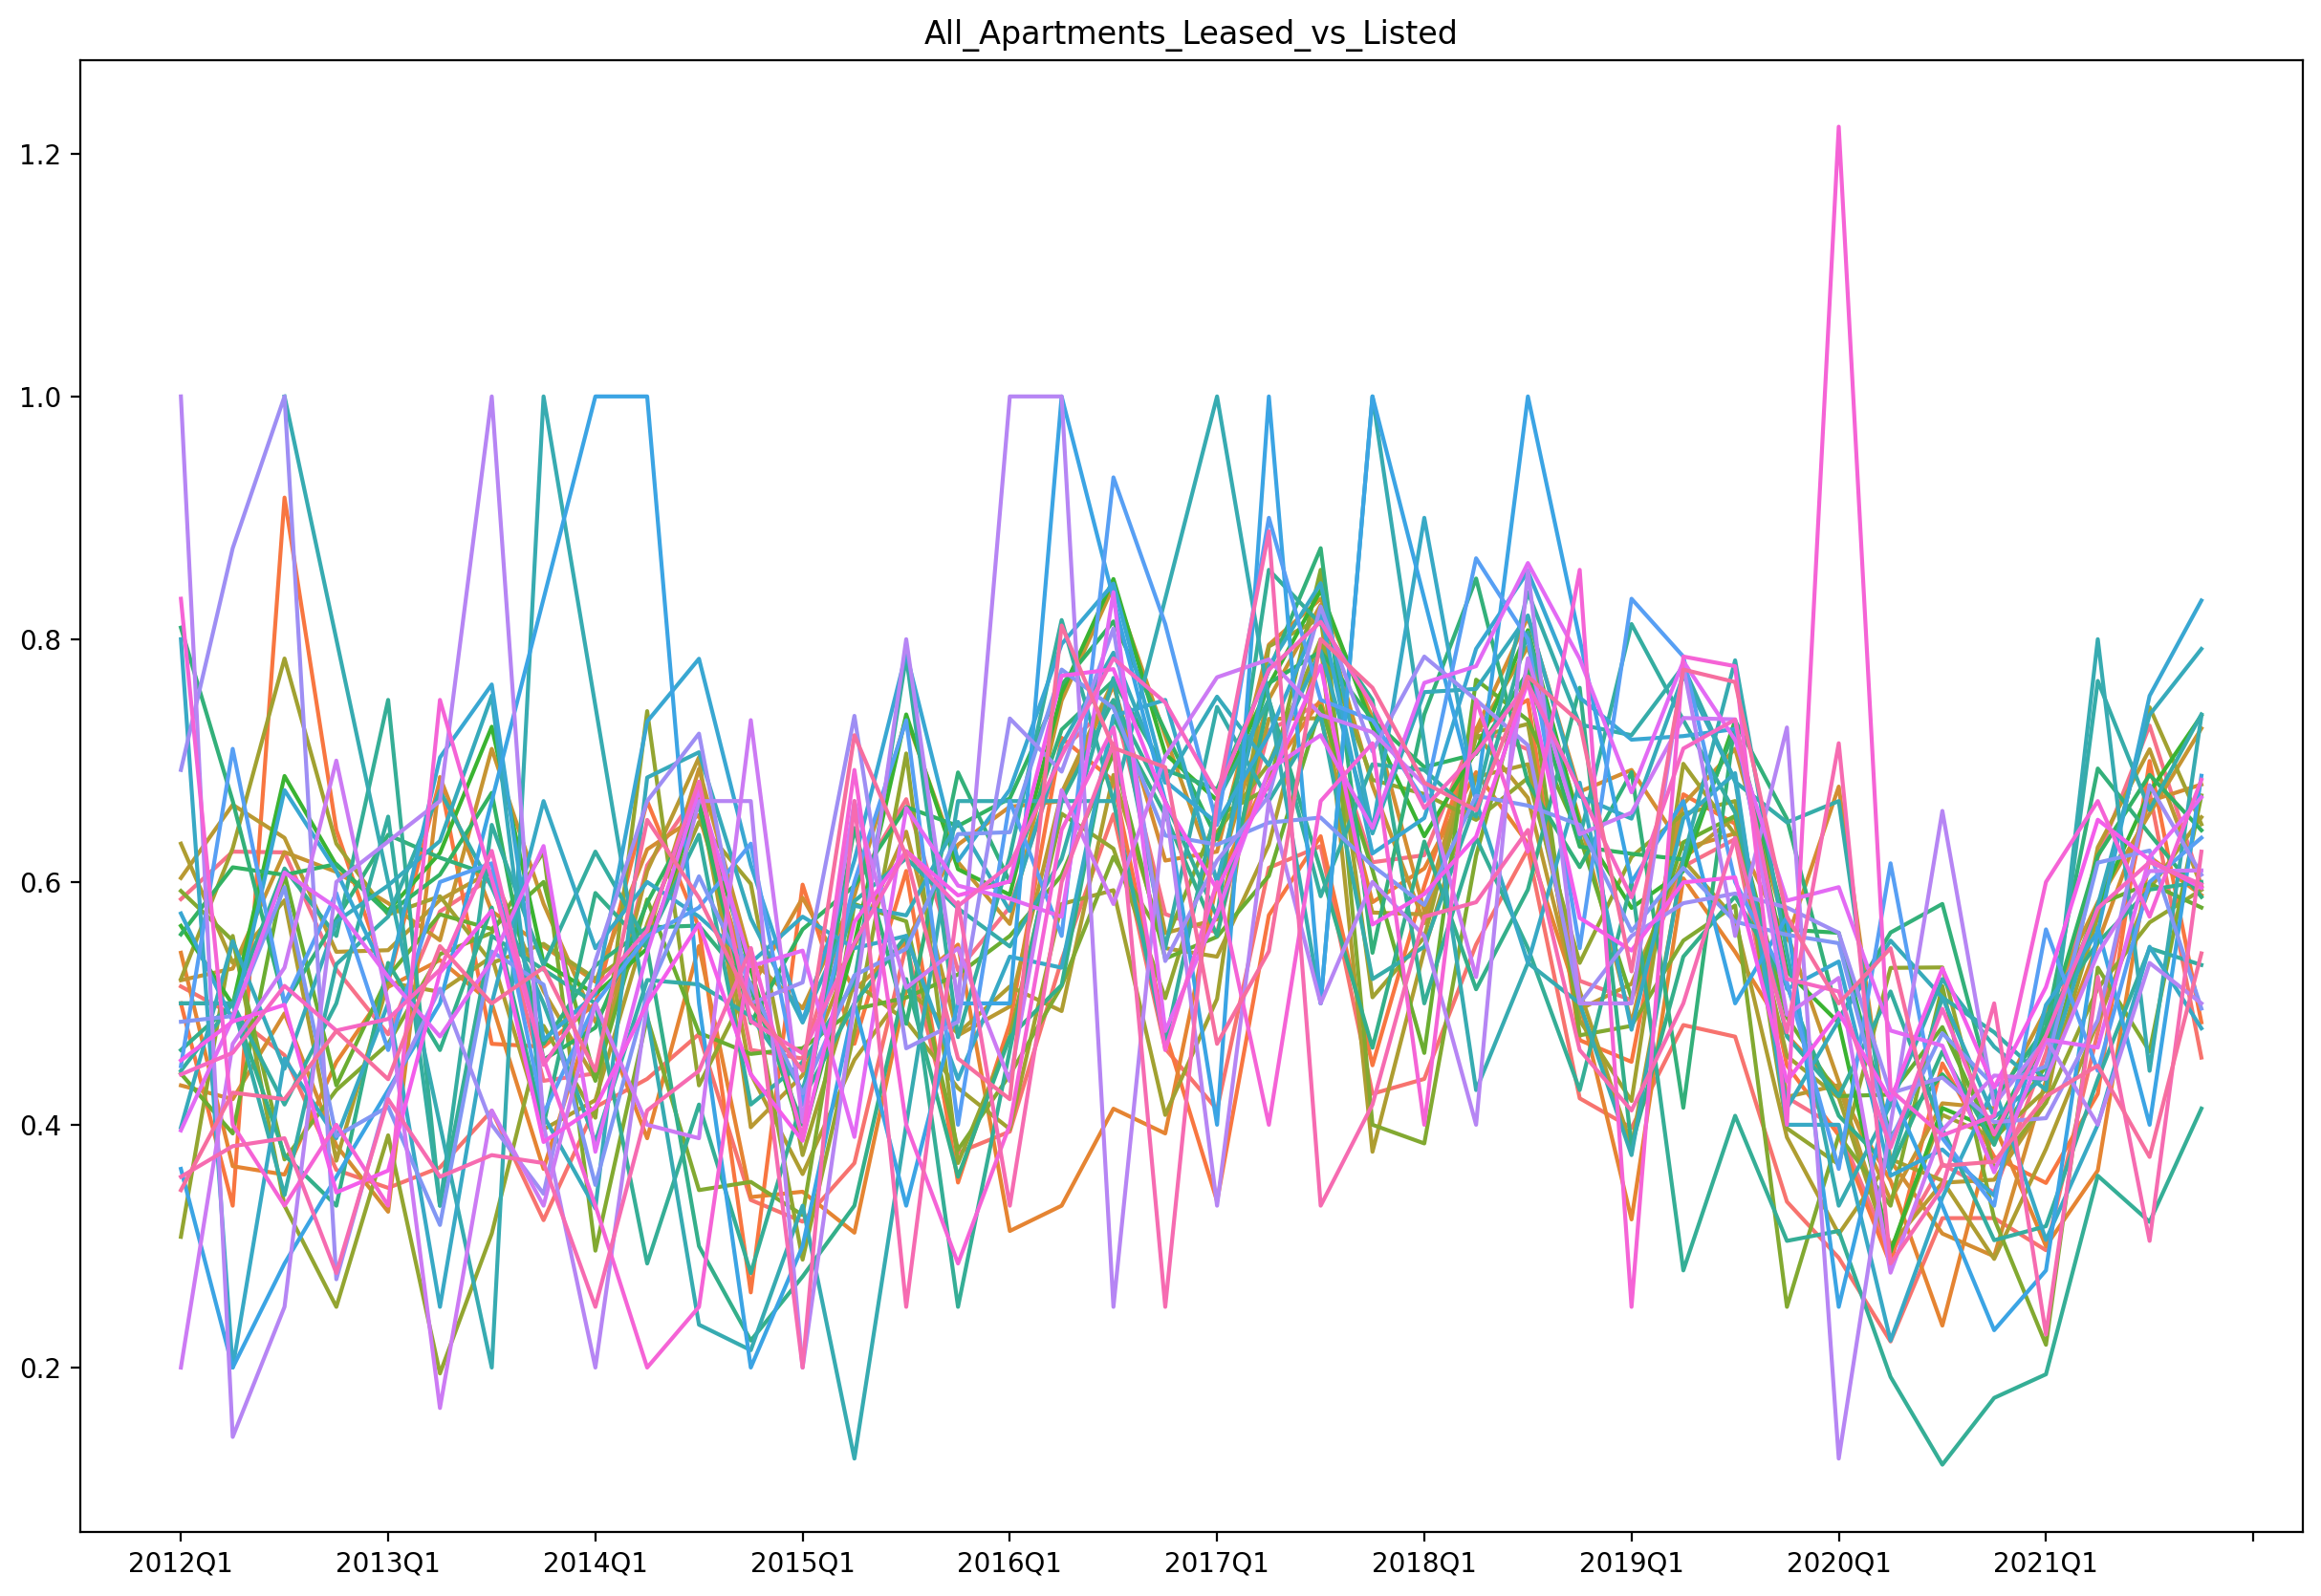

In [84]:
rental['All_Apartments_Leased_vs_Listed'] = rental['All_Apartments_Leased'] / rental['All_Apartments_Listed']
ax = sns.lineplot(x='YearQuarter', y='All_Apartments_Leased_vs_Listed', data=rental, hue='district', legend=False)
ax.title.set_text('All_Apartments_Leased_vs_Listed')
ax.yaxis.label.set_visible(False)
ax.xaxis.label.set_visible(False)
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(4))

In [85]:
# number of leased units / number of listing cannot be > 1
rental[['district', 'All_Apartments_Leased_vs_Listed']].sort_values(by='All_Apartments_Leased_vs_Listed', ascending=False).head(5)

district  All_Apartments_Leased_vs_Listed
1272      W07                         1.222222
1080      W03                         1.000000
762       E06                         1.000000
1086      W03                         1.000000
943       E10                         1.000000

In [86]:
# identify the problematic record 
location = np.where(rental['All_Apartments_Leased_vs_Listed'] == rental['All_Apartments_Leased_vs_Listed'].max())[0][0]
rental.loc[location:location,]

district  All_Apartments_Listed  All_Apartments_Leased  \
1272      W07                    9.0                   11.0   

      Bachelor_Total_Leased  Bachelor_Avg_Lease_Rate  \
1272                    NaN                      NaN   

      One_Bedroom_Total_Leased  One_Bedroom_Avg_Lease_Rate  \
1272                       5.0                      2010.0   

      Two_Bedroom_Total_Leased  Two_Bedroom_Avg_Lease_Rate  \
1272                       6.0                      2900.0   

      Three_Bedroom_Total_Leased  Three_Bedroom_Avg_Lease_Rate  Year  Quarter  \
1272                         NaN                           NaN  2020        1   

     YearQuarter  All_Apartments_Leased_vs_Listed  
1272      2020Q1                         1.222222

In [87]:
# fix the number of listing = number of leased
rental.loc[location:location, 'All_Apartments_Listed'] = rental.loc[location:location, 'All_Apartments_Leased']
rental.loc[location:location, 'All_Apartments_Leased_vs_Listed'] = 1
rental.loc[location:location,]

district  All_Apartments_Listed  All_Apartments_Leased  \
1272      W07                   11.0                   11.0   

      Bachelor_Total_Leased  Bachelor_Avg_Lease_Rate  \
1272                    NaN                      NaN   

      One_Bedroom_Total_Leased  One_Bedroom_Avg_Lease_Rate  \
1272                       5.0                      2010.0   

      Two_Bedroom_Total_Leased  Two_Bedroom_Avg_Lease_Rate  \
1272                       6.0                      2900.0   

      Three_Bedroom_Total_Leased  Three_Bedroom_Avg_Lease_Rate  Year  Quarter  \
1272                         NaN                           NaN  2020        1   

     YearQuarter  All_Apartments_Leased_vs_Listed  
1272      2020Q1                              1.0

## Plot lease counts and rates

In [88]:
rental.columns

Index(['district', 'All_Apartments_Listed', 'All_Apartments_Leased',
       'Bachelor_Total_Leased', 'Bachelor_Avg_Lease_Rate',
       'One_Bedroom_Total_Leased', 'One_Bedroom_Avg_Lease_Rate',
       'Two_Bedroom_Total_Leased', 'Two_Bedroom_Avg_Lease_Rate',
       'Three_Bedroom_Total_Leased', 'Three_Bedroom_Avg_Lease_Rate', 'Year',
       'Quarter', 'YearQuarter', 'All_Apartments_Leased_vs_Listed'],
      dtype='object')

In [89]:
lease_rates = [re.search('\w+_Lease_Rate', x).group(0) for x in rental.columns if re.search('\w+_Lease_Rate', x) is not None]
lease_count = [re.search('\w+_Total_Leased', x).group(0) for x in rental.columns if re.search('\w+_Total_Leased', x) is not None]

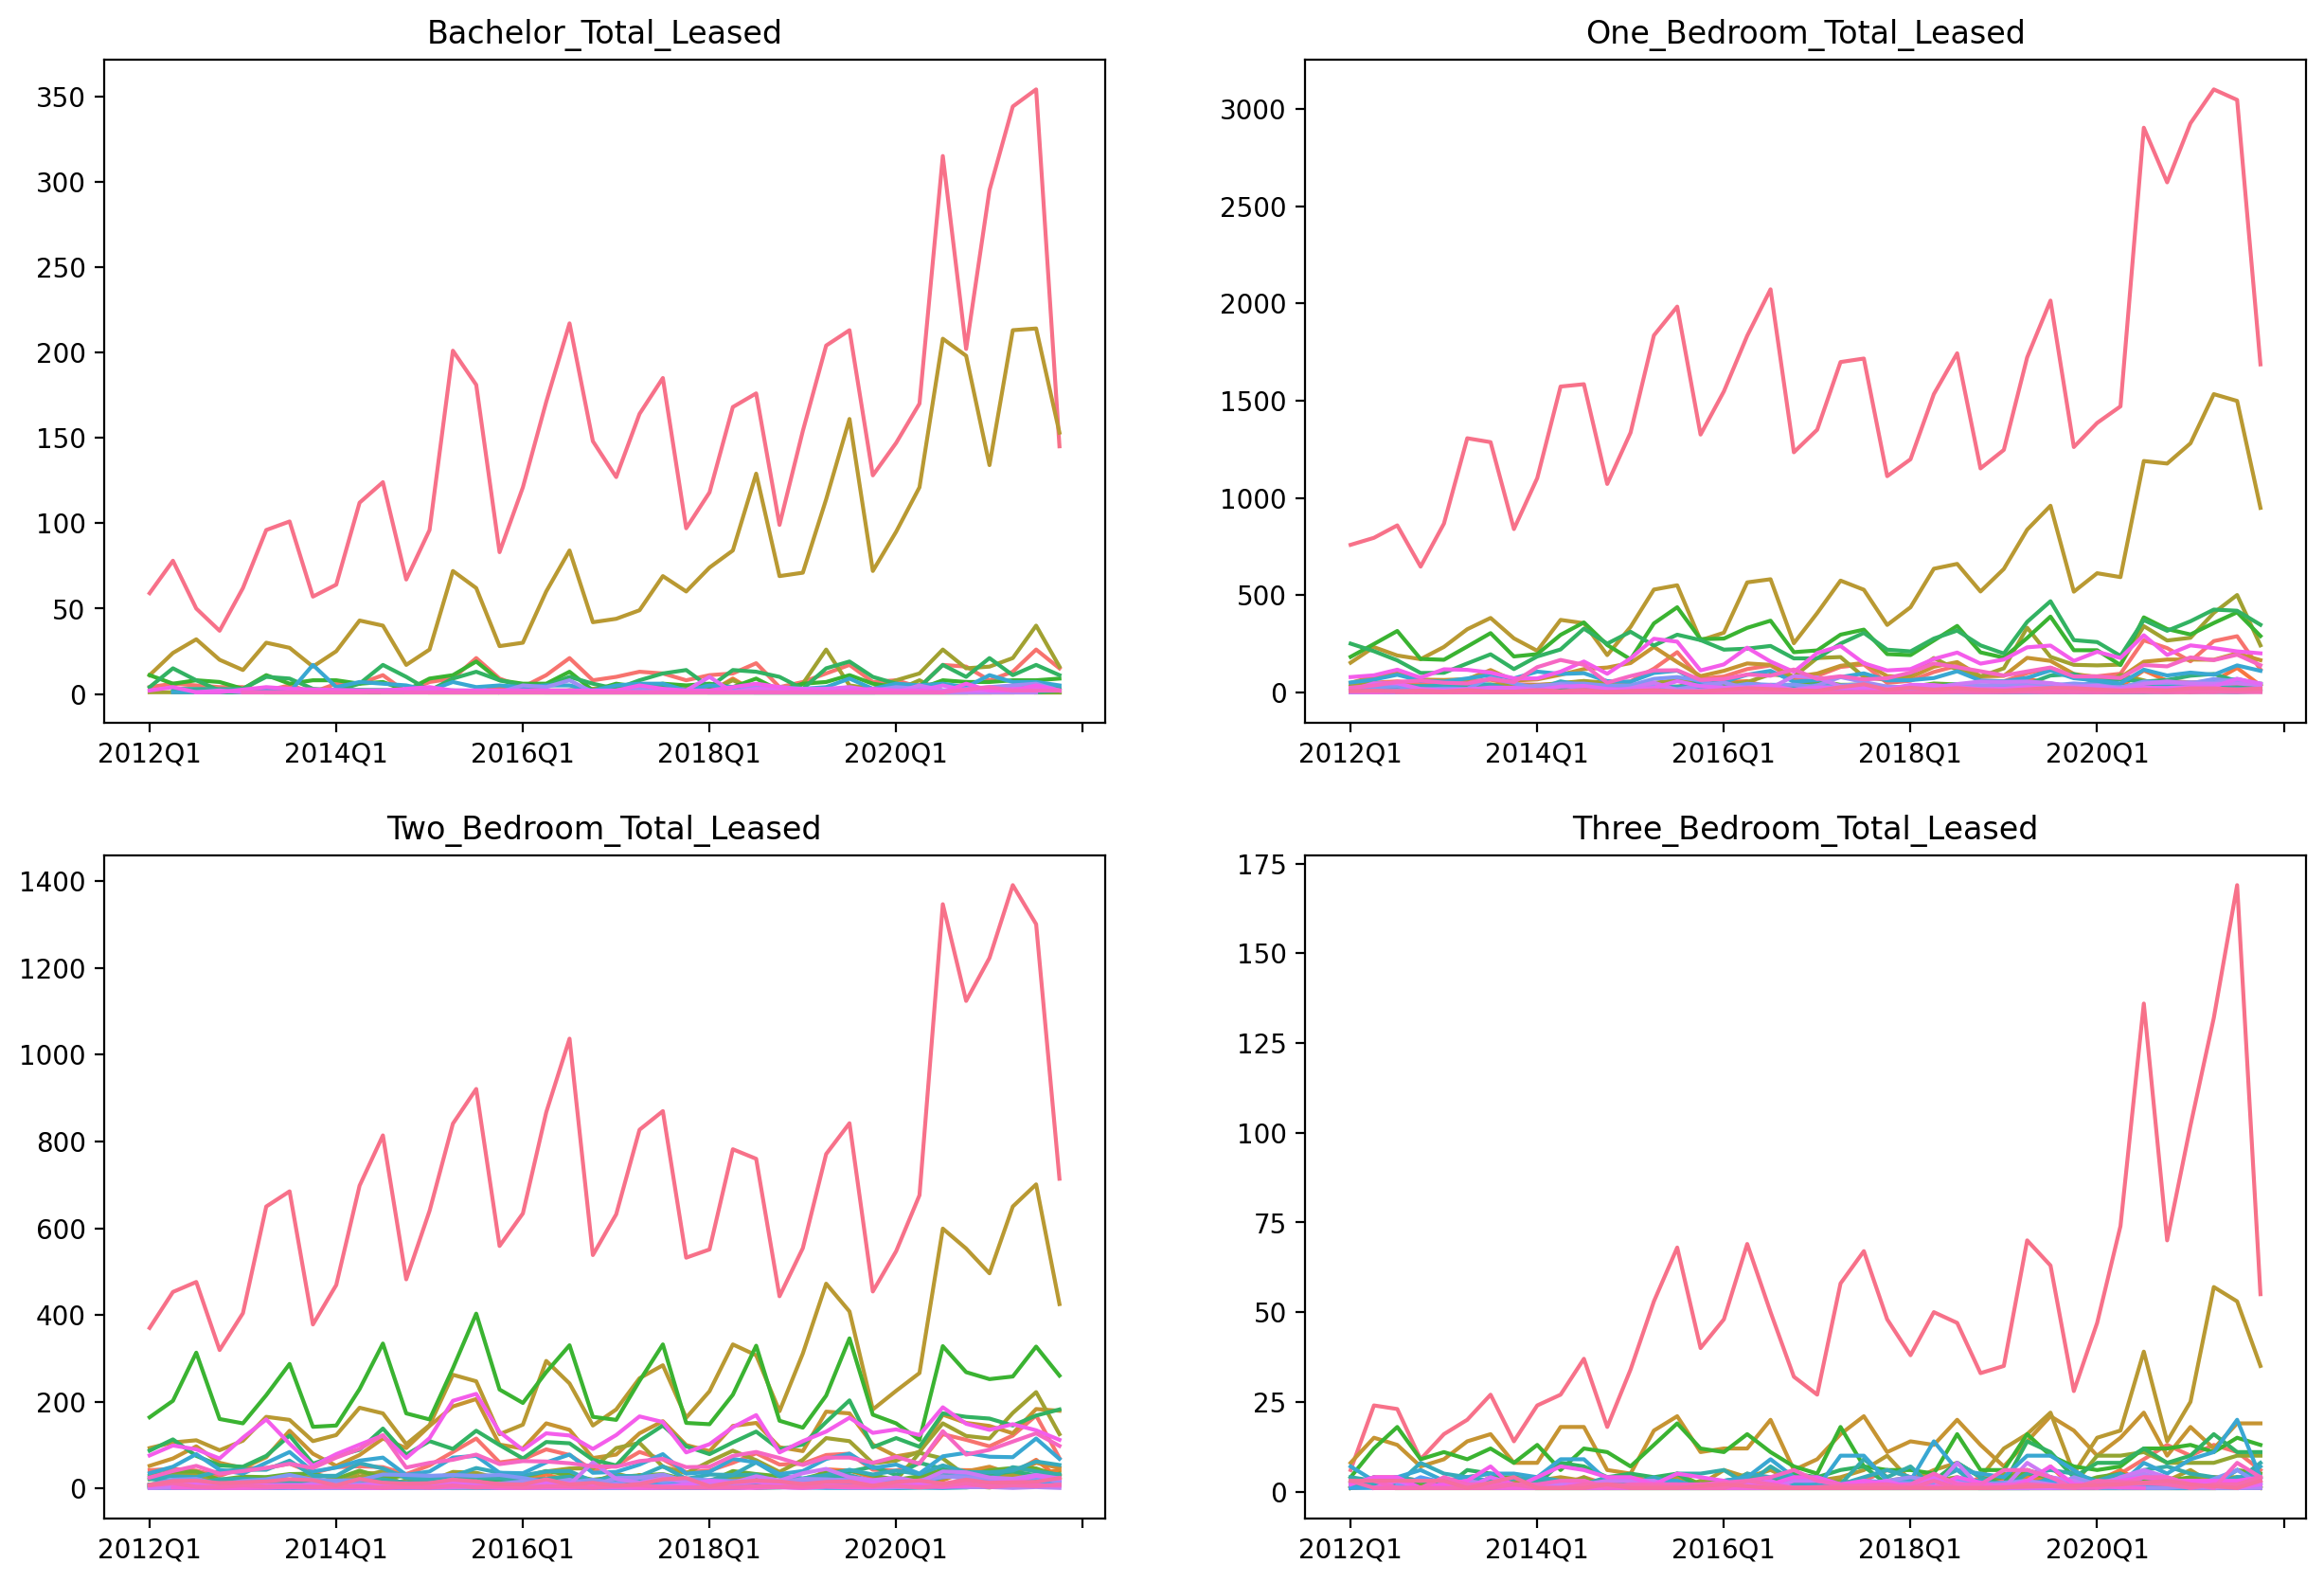

In [90]:
# plotting number of leased apartments by district
fig, axes = plt.subplots(int(len(lease_count)/2),2)
for col, ax in zip(lease_count, axes.flatten()):
    sns.lineplot(x='YearQuarter', y=col, data=rental, hue='district', legend=False, ax=ax)
    ax.title.set_text(col)
    ax.yaxis.label.set_visible(False)
    ax.xaxis.label.set_visible(False)
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(8))

In [91]:
# As expexted, C08 and C01 are the districts closest to downtown
print("Top 5 districts by number of leased apartments:")
rental[rental['YearQuarter'] == '2021Q4'].groupby('district').Bachelor_Total_Leased.mean().sort_values(ascending=False).head()

Top 5 districts by number of leased apartments:


district
C08    153.0
C01    145.0
C10     16.0
C02     15.0
C15     11.0
Name: Bachelor_Total_Leased, dtype: float64

Text(0.5, 0.98, 'Excluding C08 and C01')

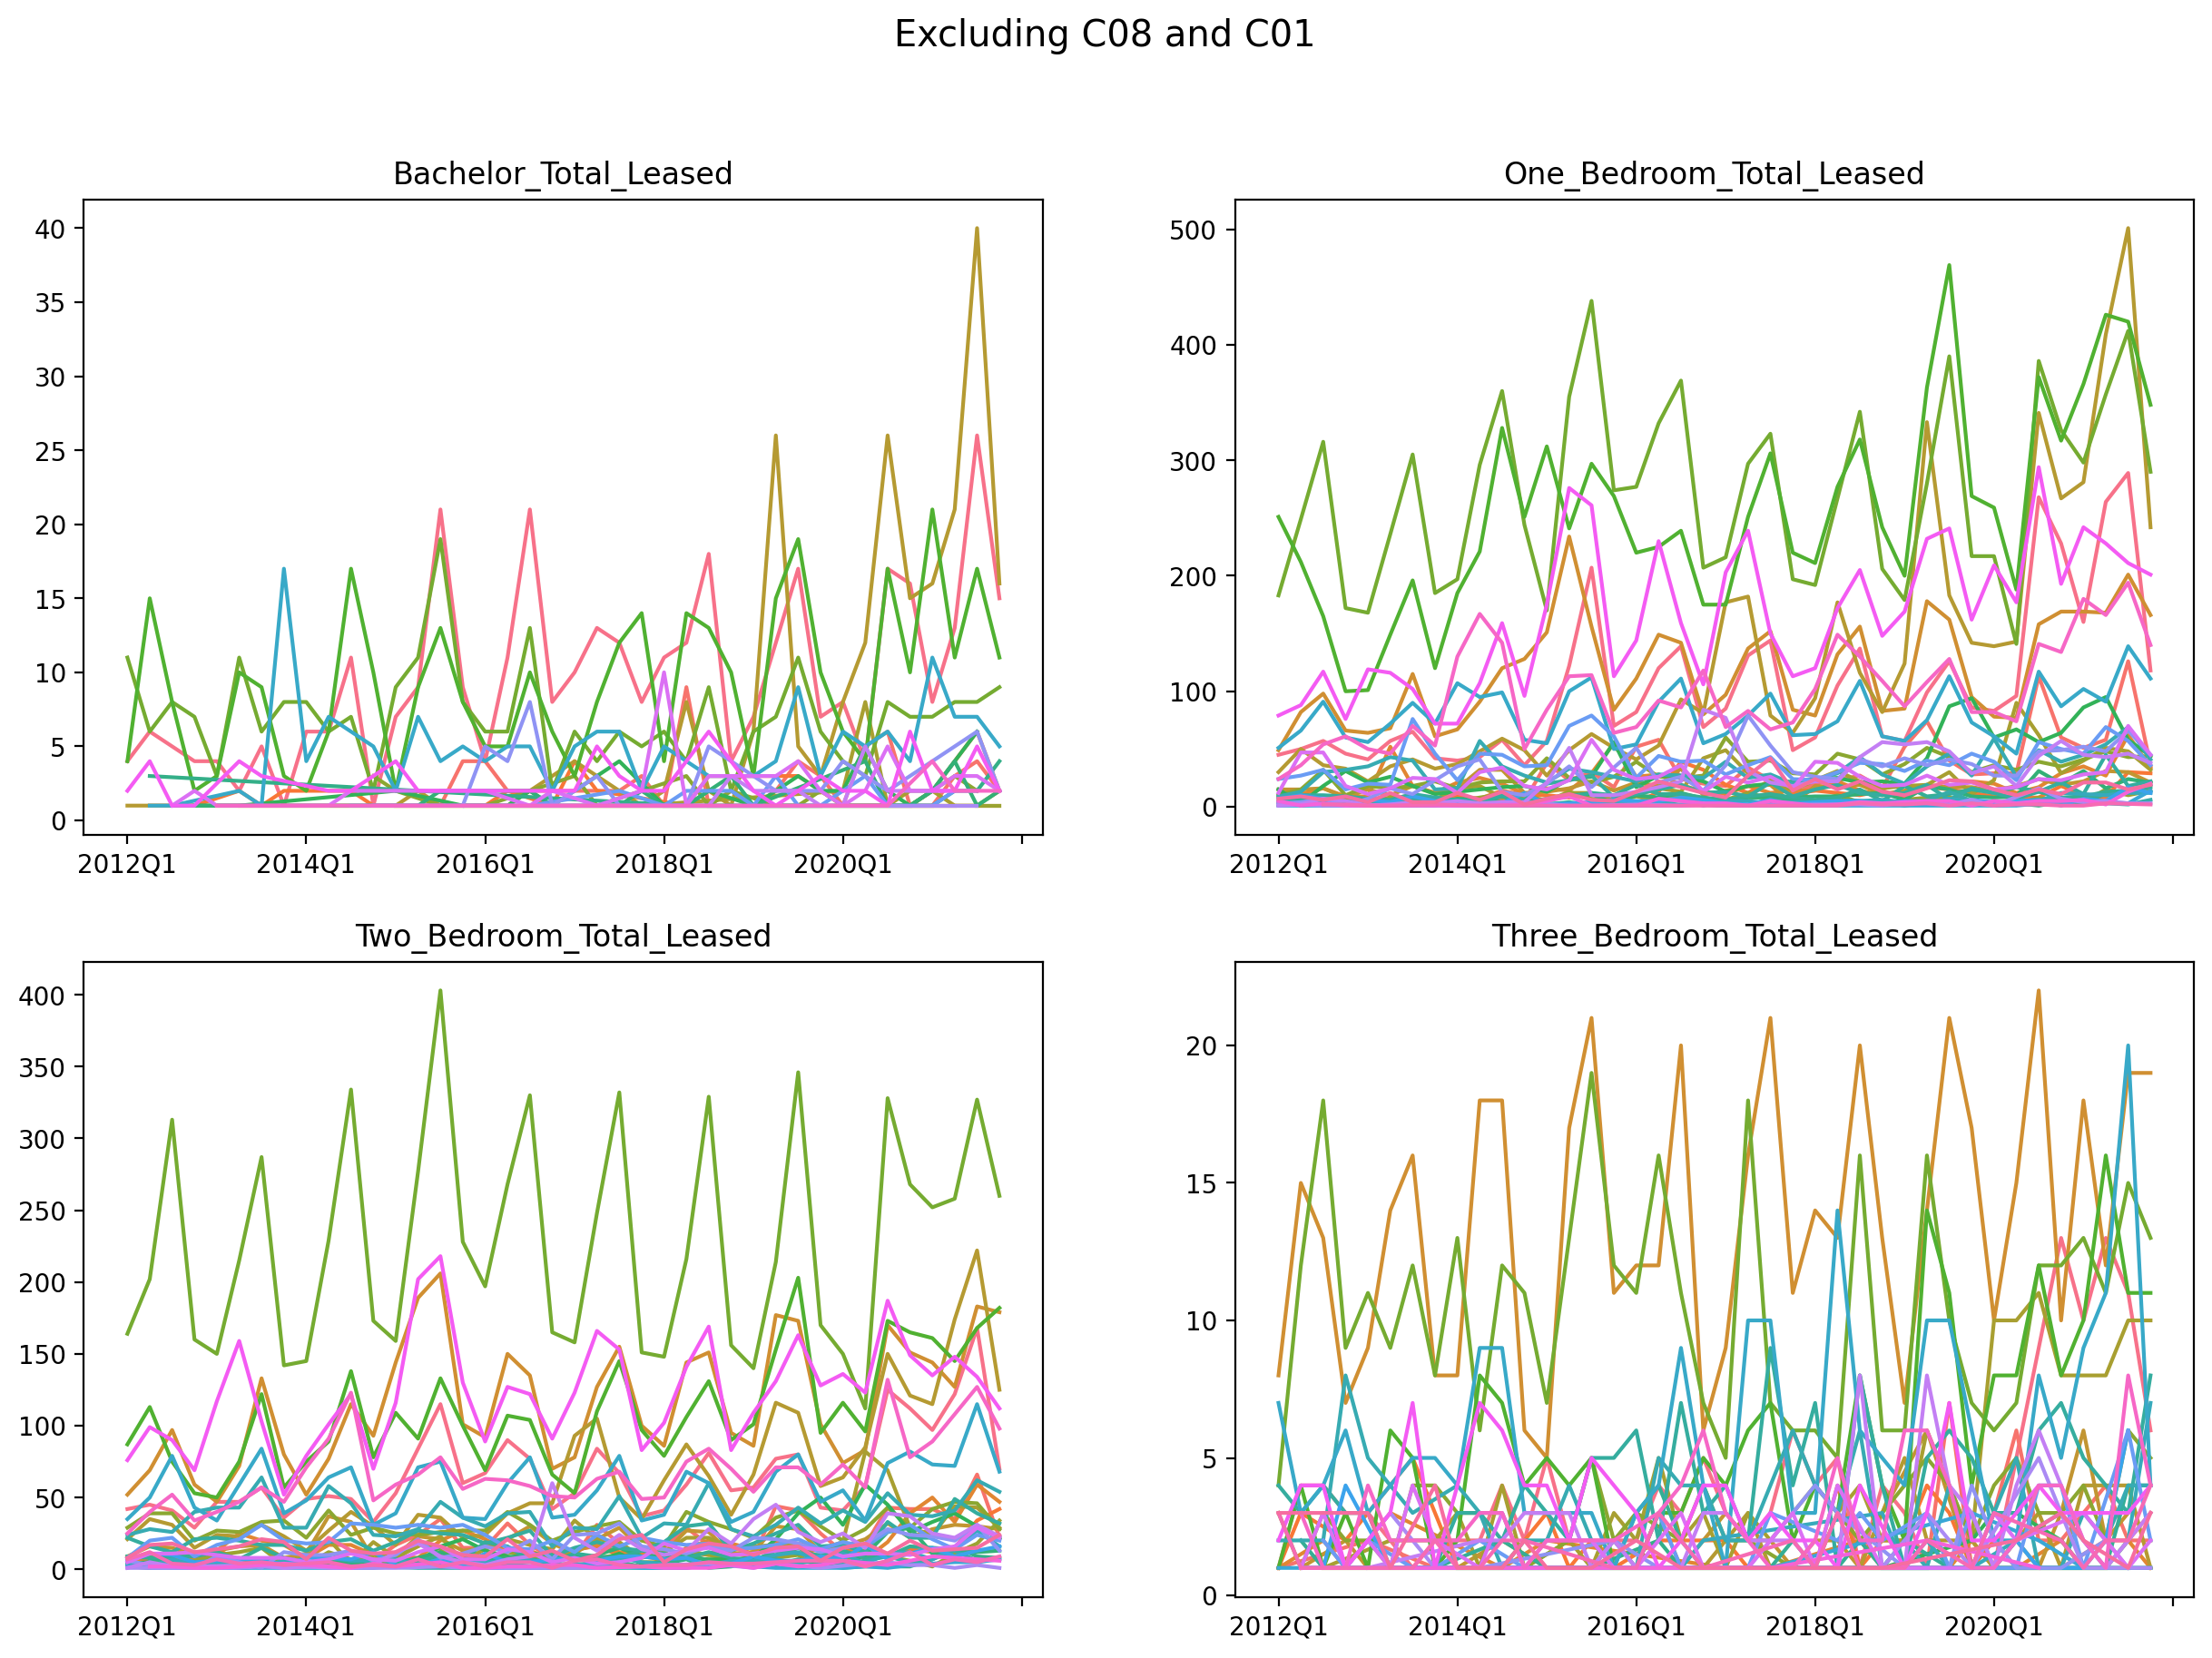

In [92]:
# Exclude the top 2 districts
fig, axes = plt.subplots(int(len(lease_count)/2),2)
for col, ax in zip(lease_count, axes.flatten()):
    sns.lineplot(x='YearQuarter', y=col, data=rental[~(rental['district'].isin(['C08', 'C01']))], hue='district', legend=False, ax=ax)
    ax.title.set_text(col)
    ax.yaxis.label.set_visible(False)
    ax.xaxis.label.set_visible(False)
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(8))
fig.suptitle('Excluding C08 and C01', size = 'x-large')

## Fix average lease rate

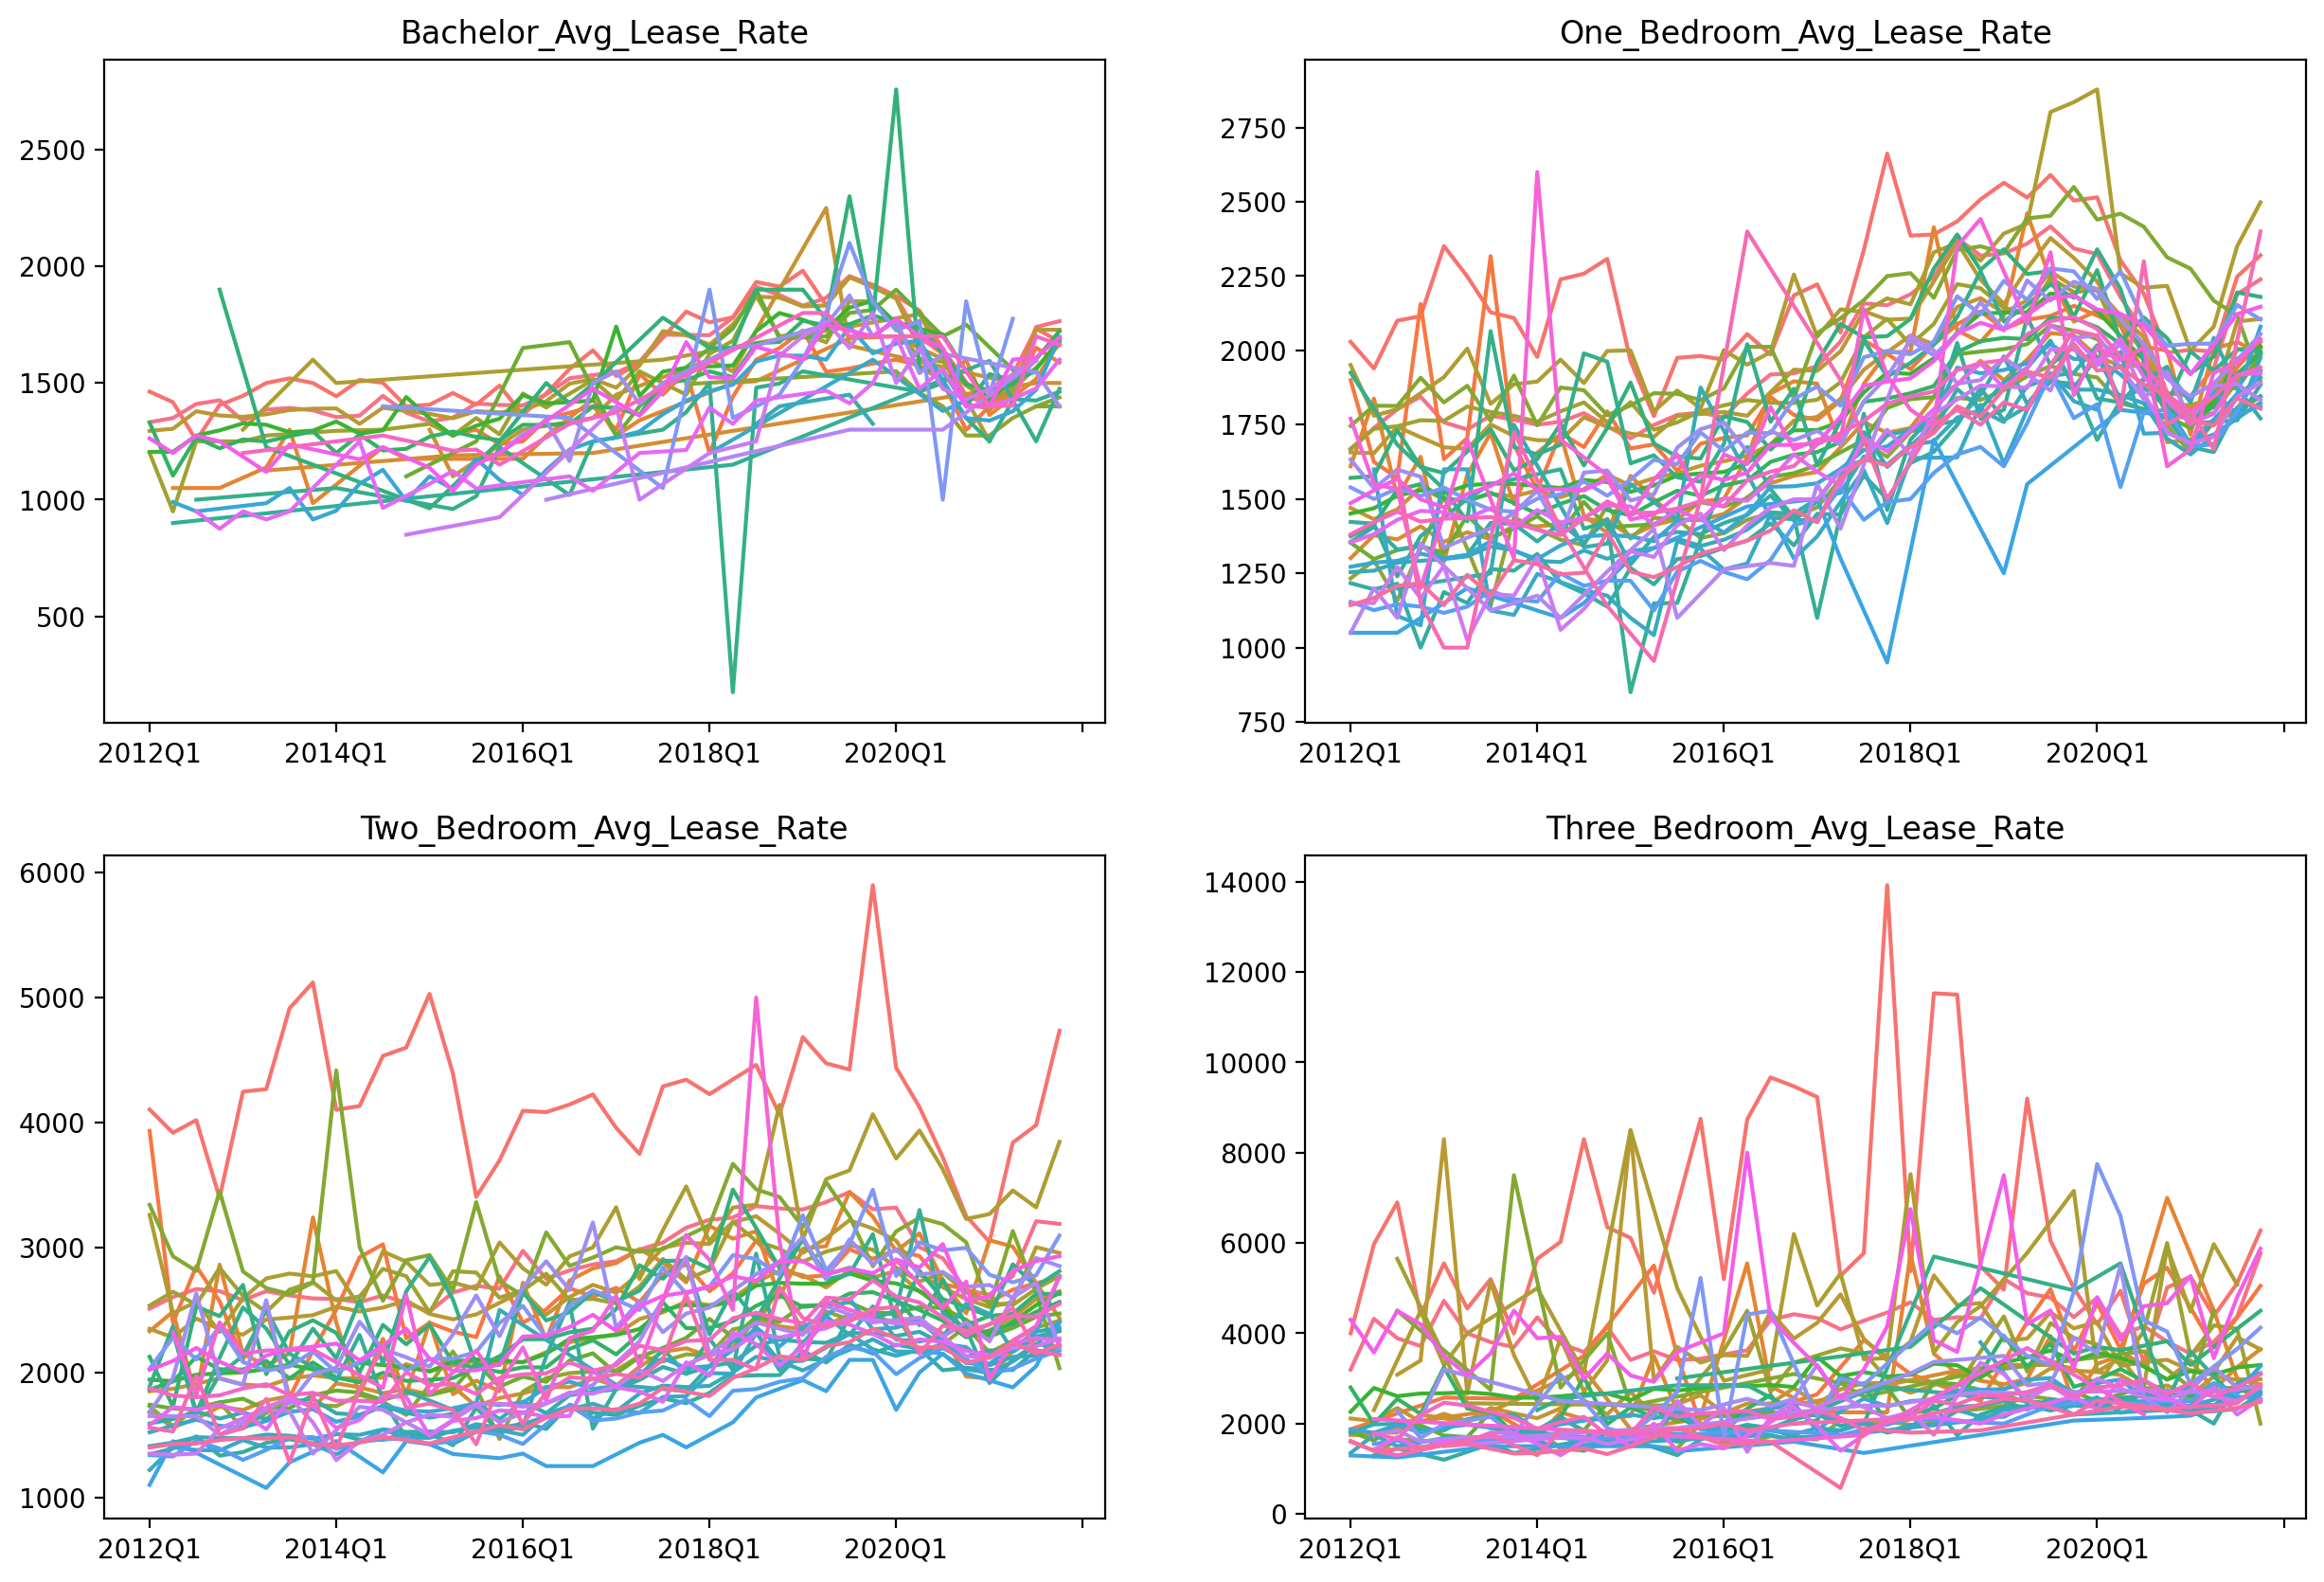

In [93]:
# plotting average lease rates of apartments by district
fig, axes = plt.subplots(int(len(lease_rates)/2),2)
for col, ax in zip(lease_rates, axes.flatten()):
    sns.lineplot(x='YearQuarter', y=col, data=rental, hue='district', legend=False, ax=ax)
    ax.title.set_text(col)
    ax.yaxis.label.set_visible(False)
    ax.xaxis.label.set_visible(False)
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(8))

In [94]:
# the suddent dip in lease rate of bachelor apartments may not make sense
location = np.where(rental['Bachelor_Avg_Lease_Rate'] == rental['Bachelor_Avg_Lease_Rate'].min())[0][0]
rental.loc[(location-1):(location+1),['district', 'Bachelor_Avg_Lease_Rate', 'YearQuarter']]

district  Bachelor_Avg_Lease_Rate YearQuarter
624      E02                   1500.0      2018Q1
625      E02                    175.0      2018Q2
626      E02                   1480.0      2018Q3

In [95]:
# $175 per month for a bachelor does not make sense
# could be manual error for missing a zero in input
# let's remove the weird data point
rental.loc[location, 'Bachelor_Avg_Lease_Rate'] = np.nan
rental.loc[(location-1):(location+1),['district', 'Bachelor_Avg_Lease_Rate', 'YearQuarter']]

district  Bachelor_Avg_Lease_Rate YearQuarter
624      E02                   1500.0      2018Q1
625      E02                      NaN      2018Q2
626      E02                   1480.0      2018Q3

In [96]:
trreb_total = pd.concat(trreb_dfs, axis=0)
trreb_total.reset_index(drop=True, inplace=True)
trreb_total.head()

district  All_Apartments_Listed  All_Apartments_Leased  \
0  TREB Total                   7096                   3804   
1  TREB Total                   8893                   4771   
2  TREB Total                   8845                   5241   
3  TREB Total                   7161                   3648   
4  TREB Total                   8816                   4277   

   Bachelor_Total_Leased  Bachelor_Avg_Lease_Rate  One_Bedroom_Total_Leased  \
0                     96                     1306                      2111   
1                    143                     1285                      2552   
2                    119                     1336                      2733   
3                     81                     1359                      1982   
4                     97                     1308                      2380   

   One_Bedroom_Avg_Lease_Rate  Two_Bedroom_Total_Leased  \
0                        1538                      1522   
1                        1556                      1950   
2                        1605                      2250   
3                        1626                      1486   
4                        1597                      1700   

   Two_Bedroom_Avg_Lease_Rate  Three_Bedroom_Total_Leased  \
0                        2089                          75   
1                        2088                         126   
2                        2097                         139   
3                        2088                          99   
4                        2114                         100   

   Three_Bedroom_Avg_Lease_Rate  Year  Quarter  
0                          2079  2012        1  
1                          2625  2012        2  
2                          2660  2012        3  
3                          2327  2012        4  
4                          2737  2013        1

In [97]:
rental

district  All_Apartments_Listed  All_Apartments_Leased  \
0         C01                 2038.0                 1194.0   
1         C01                 2160.0                 1350.0   
2         C01                 2255.0                 1408.0   
3         C01                 1917.0                 1012.0   
4         C01                 2845.0                 1350.0   
...       ...                    ...                    ...   
1395      W10                   92.0                   34.0   
1396      W10                   85.0                   36.0   
1397      W10                   78.0                   35.0   
1398      W10                   83.0                   31.0   
1399      W10                   85.0                   46.0   

      Bachelor_Total_Leased  Bachelor_Avg_Lease_Rate  \
0                      59.0                   1332.0   
1                      78.0                   1350.0   
2                      50.0                   1410.0   
3                      37.0                   1426.0   
4                      62.0                   1338.0   
...                     ...                      ...   
1395                    NaN                      NaN   
1396                    NaN                      NaN   
1397                    NaN                      NaN   
1398                    NaN                      NaN   
1399                    NaN                      NaN   

      One_Bedroom_Total_Leased  One_Bedroom_Avg_Lease_Rate  \
0                        759.0                      1666.0   
1                        795.0                      1739.0   
2                        859.0                      1802.0   
3                        647.0                      1844.0   
4                        868.0                      1758.0   
...                        ...                         ...   
1395                      11.0                      1850.0   
1396                      21.0                      1764.0   
1397                      21.0                      1748.0   
1398                      15.0                      1839.0   
1399                      19.0                      1804.0   

      Two_Bedroom_Total_Leased  Two_Bedroom_Avg_Lease_Rate  \
0                        370.0                      2510.0   
1                        453.0                      2603.0   
2                        476.0                      2667.0   
3                        319.0                      2650.0   
4                        404.0                      2578.0   
...                        ...                         ...   
1395                      20.0                      2075.0   
1396                      13.0                      2123.0   
1397                      14.0                      2243.0   
1398                      15.0                      2150.0   
1399                      24.0                      2223.0   

      Three_Bedroom_Total_Leased  Three_Bedroom_Avg_Lease_Rate  Year  Quarter  \
0                            6.0                        3194.0  2012        1   
1                           24.0                        4321.0  2012        2   
2                           23.0                        3891.0  2012        3   
3                            9.0                        3717.0  2012        4   
4                           16.0                        4719.0  2013        1   
...                          ...                           ...   ...      ...   
1395                         3.0                        2300.0  2020        4   
1396                         2.0                        2225.0  2021        1   
1397                         NaN                           NaN  2021        2   
1398                         1.0                        2350.0  2021        3   
1399                         3.0                        2483.0  2021        4   

     YearQuarter  All_Apartments_Leased_vs_Listed  
0         2012Q1                         0.585868  
1       

## Add per-bedroom statistics 

In [98]:
room_types = [re.search("(\w+)_Total_Leased", x).group(1) for x in rental.columns if re.search("(\w+)_Total_Leased", x) is not None]
room_types

['Bachelor', 'One_Bedroom', 'Two_Bedroom', 'Three_Bedroom']

In [99]:
# to compare number of leased aparatments and lease rates across different room types
# we must normalize by the number of rooms
for type in room_types:
    
    if (type == 'Bachelor') | (type == 'One_Bedroom'):
        room_num = 1
    elif type == 'Two_Bedroom':
        room_num = 2
    elif type == 'Three_Bedroom':
        room_num = 3
    
    # for number of leased apartments, we multiply by the number of bedrooms
    # e.g. 1 listing of 3-bedroom apartment = 3 listings of 1-bedroom apartment
    rental[type + '_Total_Leased_Per_Room'] = rental[type + '_Total_Leased'] * room_num
    
    # for number of leased apartments, we divide by the number of bedrooms
    # since you split the cost with your roommates
    rental[type + '_Avg_Lease_Rate_Per_Room'] = rental[type + '_Avg_Lease_Rate'] / room_num

In [100]:
rental

district  All_Apartments_Listed  All_Apartments_Leased  \
0         C01                 2038.0                 1194.0   
1         C01                 2160.0                 1350.0   
2         C01                 2255.0                 1408.0   
3         C01                 1917.0                 1012.0   
4         C01                 2845.0                 1350.0   
...       ...                    ...                    ...   
1395      W10                   92.0                   34.0   
1396      W10                   85.0                   36.0   
1397      W10                   78.0                   35.0   
1398      W10                   83.0                   31.0   
1399      W10                   85.0                   46.0   

      Bachelor_Total_Leased  Bachelor_Avg_Lease_Rate  \
0                      59.0                   1332.0   
1                      78.0                   1350.0   
2                      50.0                   1410.0   
3                      37.0                   1426.0   
4                      62.0                   1338.0   
...                     ...                      ...   
1395                    NaN                      NaN   
1396                    NaN                      NaN   
1397                    NaN                      NaN   
1398                    NaN                      NaN   
1399                    NaN                      NaN   

      One_Bedroom_Total_Leased  One_Bedroom_Avg_Lease_Rate  \
0                        759.0                      1666.0   
1                        795.0                      1739.0   
2                        859.0                      1802.0   
3                        647.0                      1844.0   
4                        868.0                      1758.0   
...                        ...                         ...   
1395                      11.0                      1850.0   
1396                      21.0                      1764.0   
1397                      21.0                      1748.0   
1398                      15.0                      1839.0   
1399                      19.0                      1804.0   

      Two_Bedroom_Total_Leased  Two_Bedroom_Avg_Lease_Rate  \
0                        370.0                      2510.0   
1                        453.0                      2603.0   
2                        476.0                      2667.0   
3                        319.0                      2650.0   
4                        404.0                      2578.0   
...                        ...                         ...   
1395                      20.0                      2075.0   
1396                      13.0                      2123.0   
1397                      14.0                      2243.0   
1398                      15.0                      2150.0   
1399                      24.0                      2223.0   

      Three_Bedroom_Total_Leased  Three_Bedroom_Avg_Lease_Rate  Year  Quarter  \
0                            6.0                        3194.0  2012        1   
1                           24.0                        4321.0  2012        2   
2                           23.0                        3891.0  2012        3   
3                            9.0                        3717.0  2012        4   
4                           16.0                        4719.0  2013        1   
...                          ...                           ...   ...      ...   
1395                         3.0                        2300.0  2020        4   
1396                         2.0                        2225.0  2021        1   
1397                         NaN                           NaN  2021        2   
1398                         1.0                        2350.0  2021        3   
1399                         3.0                        2483.0  2021        4   

     YearQuarter  All_Apartments_Leased_vs_Listed  \
0         2012Q1                         0.585868   
1     

In [101]:
rental.to_csv('./clean_data/rental.csv', index=False)

In [102]:
trreb_total.to_csv('./clean_data/trreb_total.csv', index=False)

## Join with neighbourhoods boundaries

In [103]:
neighbourhoods = gpd.read_file('./clean_data/neighbourhoods.geojson')

In [104]:
rental.loc[:,~(rental.columns.isin(['Bachelor_Total_Leased', 'Bachelor_Avg_Lease_Rate',
       'One_Bedroom_Total_Leased', 'One_Bedroom_Avg_Lease_Rate',
       'Two_Bedroom_Total_Leased', 'Two_Bedroom_Avg_Lease_Rate',
       'Three_Bedroom_Total_Leased', 'Three_Bedroom_Avg_Lease_Rate']))]

district  All_Apartments_Listed  All_Apartments_Leased  Year  Quarter  \
0         C01                 2038.0                 1194.0  2012        1   
1         C01                 2160.0                 1350.0  2012        2   
2         C01                 2255.0                 1408.0  2012        3   
3         C01                 1917.0                 1012.0  2012        4   
4         C01                 2845.0                 1350.0  2013        1   
...       ...                    ...                    ...   ...      ...   
1395      W10                   92.0                   34.0  2020        4   
1396      W10                   85.0                   36.0  2021        1   
1397      W10                   78.0                   35.0  2021        2   
1398      W10                   83.0                   31.0  2021        3   
1399      W10                   85.0                   46.0  2021        4   

     YearQuarter  All_Apartments_Leased_vs_Listed  \
0         2012Q1                         0.585868   
1         2012Q2                         0.625000   
2         2012Q3                         0.624390   
3         2012Q4                         0.527908   
4         2013Q1                         0.474517   
...          ...                              ...   
1395      2020Q4                         0.369565   
1396      2021Q1                         0.423529   
1397      2021Q2                         0.448718   
1398      2021Q3                         0.373494   
1399      2021Q4                         0.541176   

      Bachelor_Total_Leased_Per_Room  Bachelor_Avg_Lease_Rate_Per_Room  \
0                               59.0                            1332.0   
1                               78.0                            1350.0   
2                               50.0                            1410.0   
3                               37.0                            1426.0   
4                               62.0                            1338.0   
...                              ...                               ...   
1395                             NaN                               NaN   
1396                             NaN                               NaN   
1397                             NaN                               NaN   
1398                             NaN                               NaN   
1399                             NaN                               NaN   

      One_Bedroom_Total_Leased_Per_Room  One_Bedroom_Avg_Lease_Rate_Per_Room  \
0                                 759.0                               1666.0   
1                                 795.0                               1739.0   
2                                 859.0                               1802.0   
3                                 647.0                               1844.0   
4                                 868.0                               1758.0   
...                                 ...                                  ...   
1395                               11.0                               1850.0   
1396                               21.0                               1764.0   
1397                               21.0                               1748.0   
1398                               15.0                               1839.0   
1399                               19.0                               1804.0   

      Two_Bedroom_Total_Leased_Per_Room  Two_Bedroom_Avg_Lease_Rate_Per_Room  \
0                                 740.0                               1255.0   
1                                 906.0                               1301.5   
2                                 952.0                               1333.5   
3                                 638.0                               1325.0   
4                                 808.0                               1289.0   
...                                 ...                                  ...   
1395                 

In [105]:
neighbourhoods_rental = neighbourhoods[['Neighbourhood', 'hood_id', 'district', 'geometry']].merge(rental.loc[:,~(rental.columns.isin(['Bachelor_Total_Leased', 'Bachelor_Avg_Lease_Rate',
                                                                                                                                       'One_Bedroom_Total_Leased', 'One_Bedroom_Avg_Lease_Rate',
                                                                                                                                       'Two_Bedroom_Total_Leased', 'Two_Bedroom_Avg_Lease_Rate',
                                                                                                                                       'Three_Bedroom_Total_Leased', 'Three_Bedroom_Avg_Lease_Rate']))], 
                                                                                                   on='district')
neighbourhoods_rental

Neighbourhood hood_id district  \
0          Yonge-St.Clair      97      C02   
1          Yonge-St.Clair      97      C02   
2          Yonge-St.Clair      97      C02   
3          Yonge-St.Clair      97      C02   
4          Yonge-St.Clair      97      C02   
...                   ...     ...      ...   
5595  Mount Pleasant West     104      C10   
5596  Mount Pleasant West     104      C10   
5597  Mount Pleasant West     104      C10   
5598  Mount Pleasant West     104      C10   
5599  Mount Pleasant West     104      C10   

                                               geometry  \
0     POLYGON ((-79.39115 43.68108, -79.39137 43.680...   
1     POLYGON ((-79.39115 43.68108, -79.39137 43.680...   
2     POLYGON ((-79.39115 43.68108, -79.39137 43.680...   
3     POLYGON ((-79.39115 43.68108, -79.39137 43.680...   
4     POLYGON ((-79.39115 43.68108, -79.39137 43.680...   
...                                                 ...   
5595  POLYGON ((-79.39607 43.69566, -79.39616 43.696...   
5596  POLYGON ((-79.39607 43.69566, -79.39616 43.696...   
5597  POLYGON ((-79.39607 43.69566, -79.39616 43.696...   
5598  POLYGON ((-79.39607 43.69566, -79.39616 43.696...   
5599  POLYGON ((-79.39607 43.69566, -79.39616 43.696...   

      All_Apartments_Listed  All_Apartments_Leased  Year  Quarter YearQuarter  \
0                     179.0                   92.0  2012        1      2012Q1   
1                     214.0                  105.0  2012        2      2012Q2   
2                     234.0                  107.0  2012        3      2012Q3   
3                     226.0                   82.0  2012        4      2012Q4   
4                     273.0                   95.0  2013        1      2013Q1   
...                     ...                    ...   ...      ...         ...   
5595                 1038.0                  404.0  2020        4      2020Q4   
5596                  970.0                  416.0  2021        1      2021Q1   
5597                 1064.0                  608.0  2021        2      2021Q2   
5598                 1031.0                  767.0  2021        3      2021Q3   
5599                  593.0                  384.0  2021        4      2021Q4   

      All_Apartments_Leased_vs_Listed  Bachelor_Total_Leased_Per_Room  \
0                            0.513966                             4.0   
1                            0.490654                             6.0   
2                            0.457265                             5.0   
3                            0.362832                             4.0   
4                            0.347985                             4.0   
...                               ...                             ...   
5595                         0.389210                            15.0   
5596                         0.428866                            16.0   
5597                         0.571429                            21.0   
5598                         0.743938                            40.0   
5599                         0.647555                            16.0   

      Bachelor_Avg_Lease_Rate_Per_Room  One_Bedroom_Total_Leased_Per_Room  \
0                               1463.0                               45.0   
1                               1418.0                               50.0   
2                               1254.0                               57.0   
3                               1406.0                               46.0   
4                               1445.0                               41.0   
...                                ...                                ...   
5595                            1489.0                              267.0   
5596                            1425.0                              281.0   
5597                            1473.0                              409.0   
5598                            1566.0                              501.0   
5599                            1666.0               

### Check missing data

<AxesSubplot:>

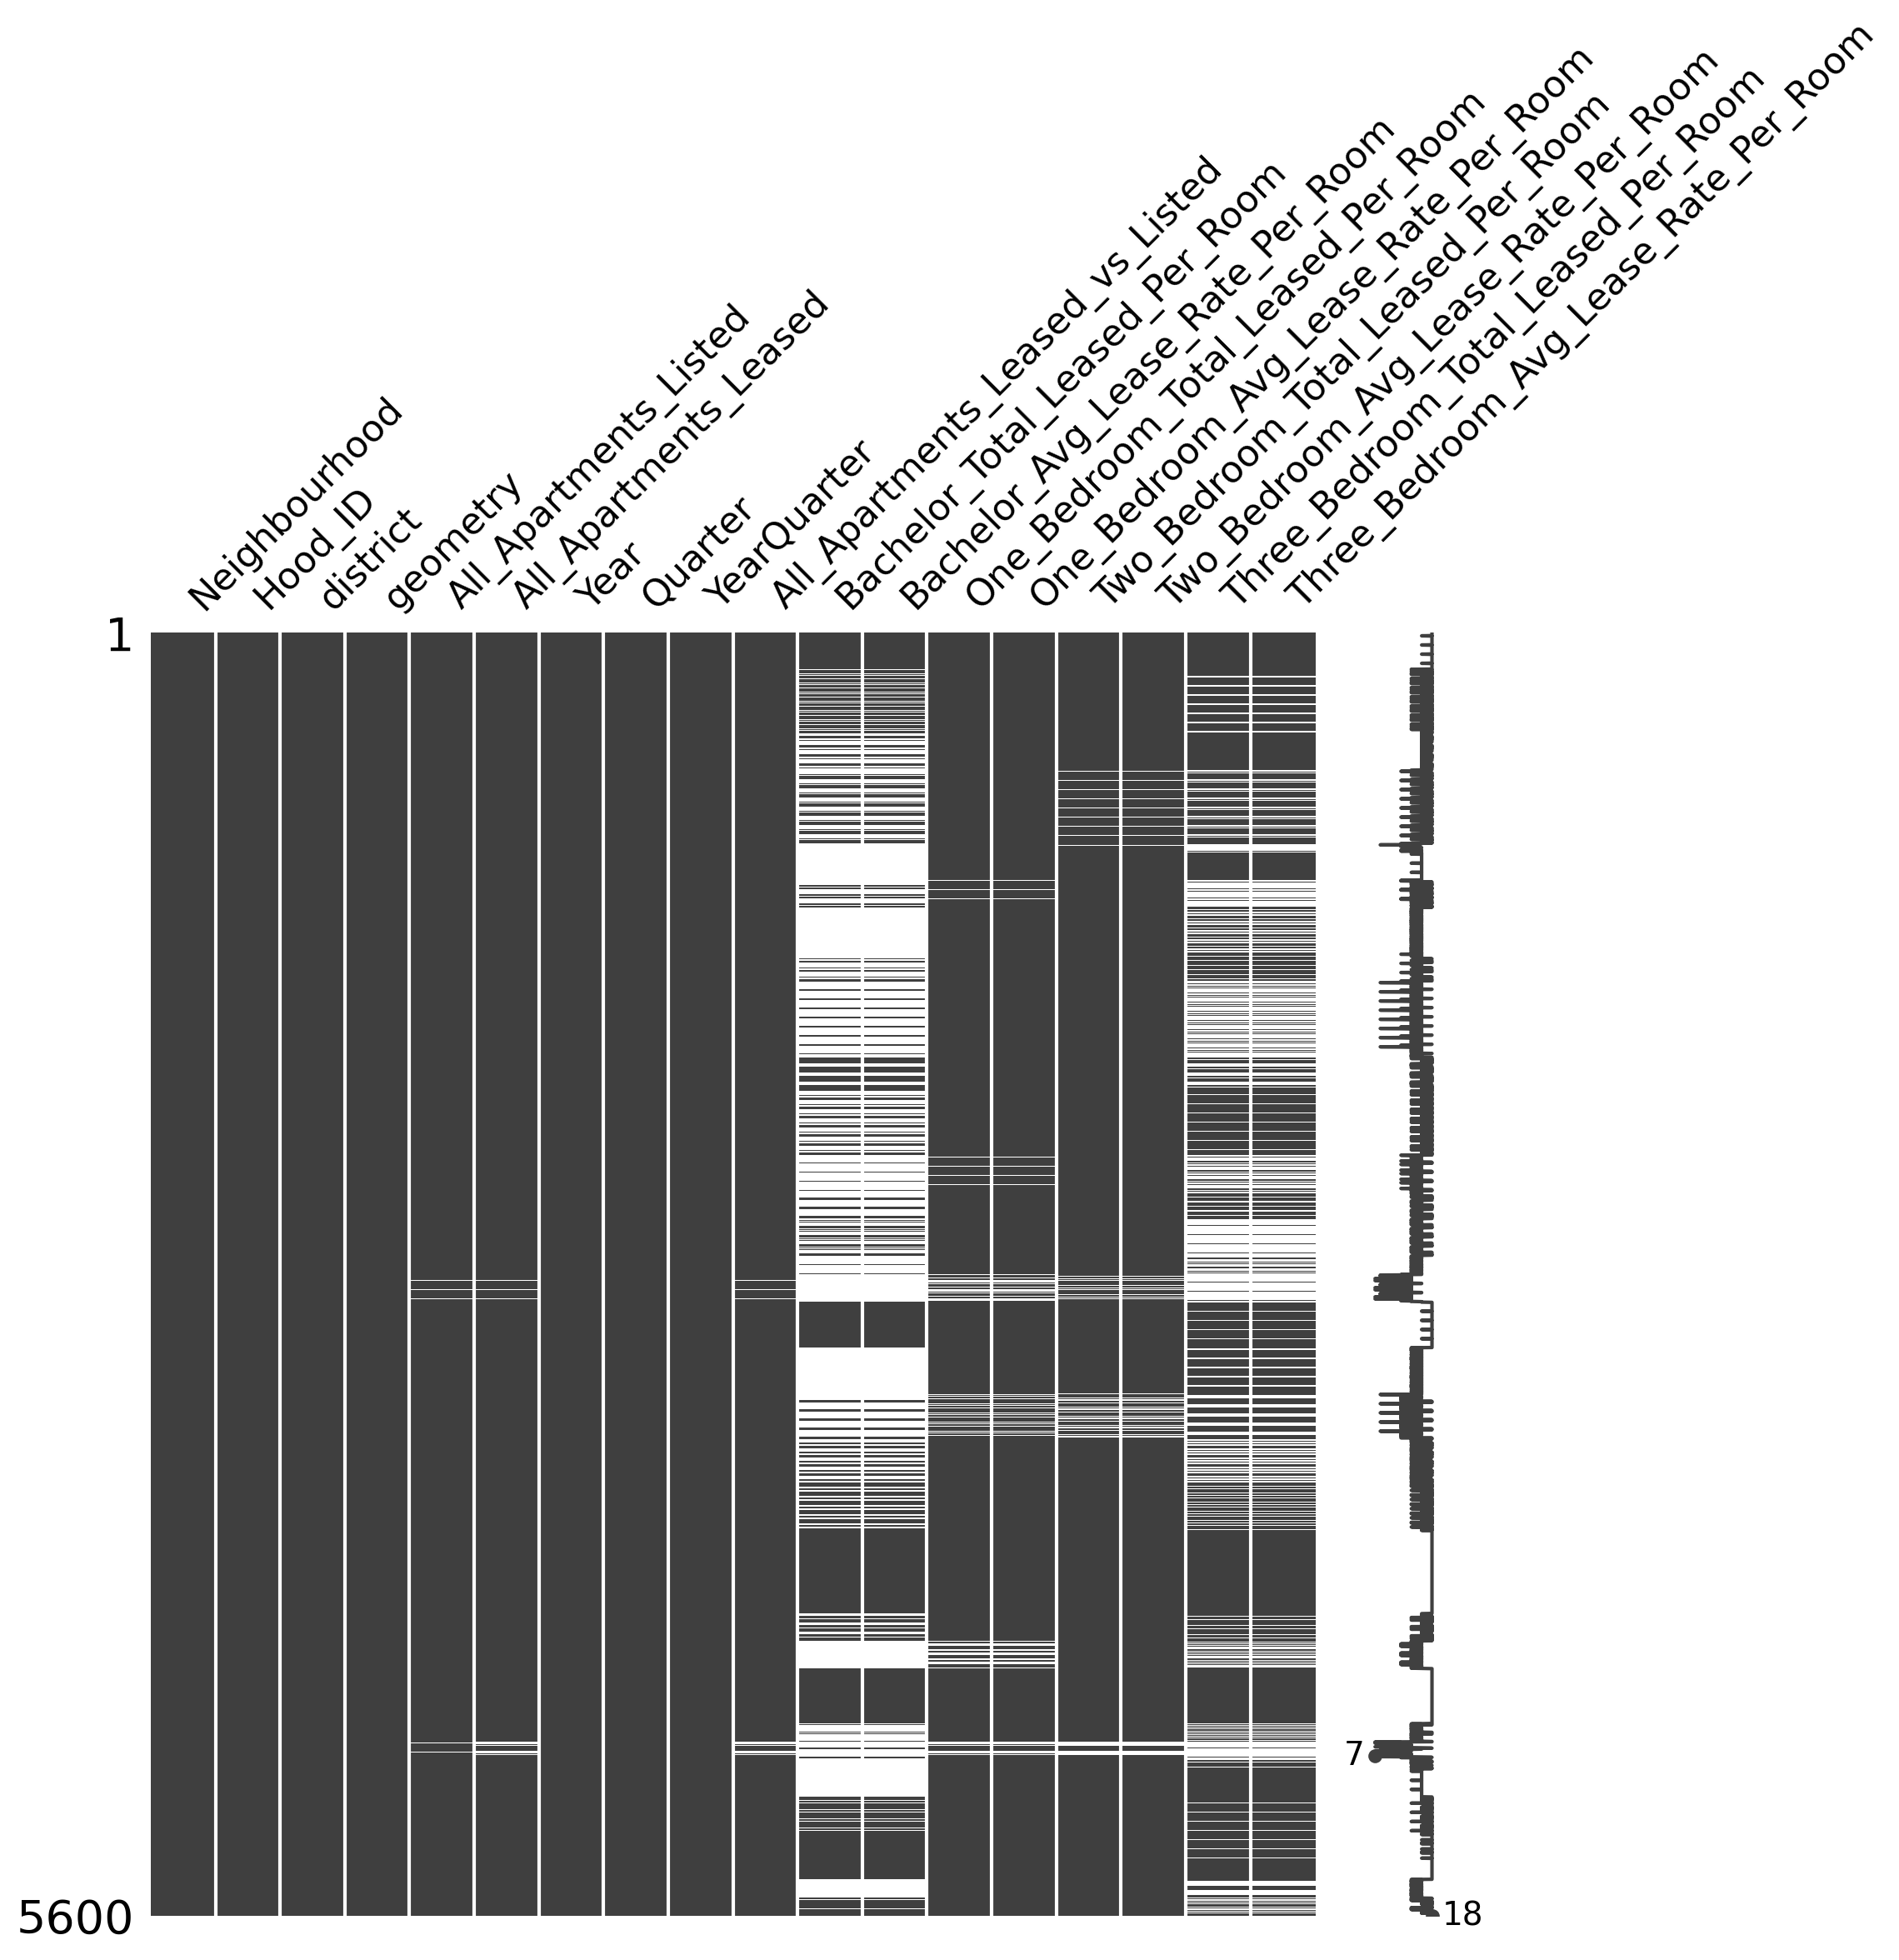

In [106]:
msno.matrix(neighbourhoods_rental, figsize=(10,10))

In [107]:
print("Percentage of missing data")
(neighbourhoods_rental.isna().sum(axis=0).sort_values(ascending=False) / neighbourhoods_rental.shape[0])*100

Percentage of missing data


Bachelor_Avg_Lease_Rate_Per_Room         54.964286
Bachelor_Total_Leased_Per_Room           54.910714
Three_Bedroom_Avg_Lease_Rate_Per_Room    30.053571
Three_Bedroom_Total_Leased_Per_Room      30.053571
One_Bedroom_Avg_Lease_Rate_Per_Room       4.232143
One_Bedroom_Total_Leased_Per_Room         4.232143
Two_Bedroom_Avg_Lease_Rate_Per_Room       3.160714
Two_Bedroom_Total_Leased_Per_Room         3.160714
All_Apartments_Leased_vs_Listed           1.000000
All_Apartments_Leased                     1.000000
All_Apartments_Listed                     0.285714
hood_id                                   0.000000
YearQuarter                               0.000000
Quarter                                   0.000000
Year                                      0.000000
geometry                                  0.000000
district                                  0.000000
Neighbourhood                             0.000000
dtype: float64

### Drop bachelor apartments

In [108]:
# drop Bachelor apartments columns since over 50% of the data is missing
neighbourhoods_rental.drop(columns=['Bachelor_Avg_Lease_Rate_Per_Room', 'Bachelor_Total_Leased_Per_Room'], inplace=True)

### Forward fill NA values

In [109]:
# row 14 is one of the rows with NA
# missing data for Yonge-St.Clair in 2015 Q3 
neighbourhoods_rental[neighbourhoods_rental.isna().sum(axis=1) != 0].head(1)

Neighbourhood hood_id district  \
14  Yonge-St.Clair      97      C02   

                                             geometry  All_Apartments_Listed  \
14  POLYGON ((-79.39115 43.68108, -79.39137 43.680...                  626.0   

    All_Apartments_Leased  Year  Quarter YearQuarter  \
14                  343.0  2015        3      2015Q3   

    All_Apartments_Leased_vs_Listed  One_Bedroom_Total_Leased_Per_Room  \
14                         0.547923                              207.0   

    One_Bedroom_Avg_Lease_Rate_Per_Room  Two_Bedroom_Total_Leased_Per_Room  \
14                               1975.0                              230.0   

    Two_Bedroom_Avg_Lease_Rate_Per_Room  Three_Bedroom_Total_Leased_Per_Room  \
14                               1702.5                                  NaN   

    Three_Bedroom_Avg_Lease_Rate_Per_Room  
14                                    NaN

In [110]:
# check rows 13 to 15
# data for Yonge-St.Clair in 2015 Q2, Q3, Q4 
neighbourhoods_rental.iloc[13:16, 4:]

All_Apartments_Listed  All_Apartments_Leased  Year  Quarter YearQuarter  \
13                  589.0                  217.0  2015        2      2015Q2   
14                  626.0                  343.0  2015        3      2015Q3   
15                  374.0                  141.0  2015        4      2015Q4   

    All_Apartments_Leased_vs_Listed  One_Bedroom_Total_Leased_Per_Room  \
13                         0.368421                              122.0   
14                         0.547923                              207.0   
15                         0.377005                               70.0   

    One_Bedroom_Avg_Lease_Rate_Per_Room  Two_Bedroom_Total_Leased_Per_Room  \
13                               1779.0                              168.0   
14                               1975.0                              230.0   
15                               1981.0                              120.0   

    Two_Bedroom_Avg_Lease_Rate_Per_Room  Three_Bedroom_Total_Leased_Per_Room  \
13                               2197.0                                  6.0   
14                               1702.5                                  NaN   
15                               1848.5                                  6.0   

    Three_Bedroom_Avg_Lease_Rate_Per_Room  
13                            1633.333333  
14                                    NaN  
15                            2916.666667

In [111]:
# missing data in 2015 Q3 is interpolated by the data in 2015 Q2 and 2015 Q4
pd.DataFrame(neighbourhoods_rental.iloc[13:16,4:]).interpolate(method='linear', axis=0)

All_Apartments_Listed  All_Apartments_Leased  Year  Quarter YearQuarter  \
13                  589.0                  217.0  2015        2      2015Q2   
14                  626.0                  343.0  2015        3      2015Q3   
15                  374.0                  141.0  2015        4      2015Q4   

    All_Apartments_Leased_vs_Listed  One_Bedroom_Total_Leased_Per_Room  \
13                         0.368421                              122.0   
14                         0.547923                              207.0   
15                         0.377005                               70.0   

    One_Bedroom_Avg_Lease_Rate_Per_Room  Two_Bedroom_Total_Leased_Per_Room  \
13                               1779.0                              168.0   
14                               1975.0                              230.0   
15                               1981.0                              120.0   

    Two_Bedroom_Avg_Lease_Rate_Per_Room  Three_Bedroom_Total_Leased_Per_Room  \
13                               2197.0                                  6.0   
14                               1702.5                                  6.0   
15                               1848.5                                  6.0   

    Three_Bedroom_Avg_Lease_Rate_Per_Room  
13                            1633.333333  
14                            2275.000000  
15                            2916.666667

In [112]:
len(neighbourhoods_rental.hood_id.unique())

140

In [113]:
# first forward fill within each neighbourhood only
# then assume the first record is NA, we do backward fill within each neighbourhood
for hood in neighbourhoods_rental.hood_id.unique():
    neighbourhoods_rental.loc[neighbourhoods_rental['hood_id'] == hood, ~(neighbourhoods_rental.columns.isin(['Neighbourhood', 'hood_id', 'district', 'geometry']))] = neighbourhoods_rental.loc[neighbourhoods_rental['hood_id'] == hood, ~(neighbourhoods_rental.columns.isin(['Neighbourhood', 'hood_id', 'district', 'geometry']))].ffill(axis=0).bfill(axis=0).values

<AxesSubplot:>

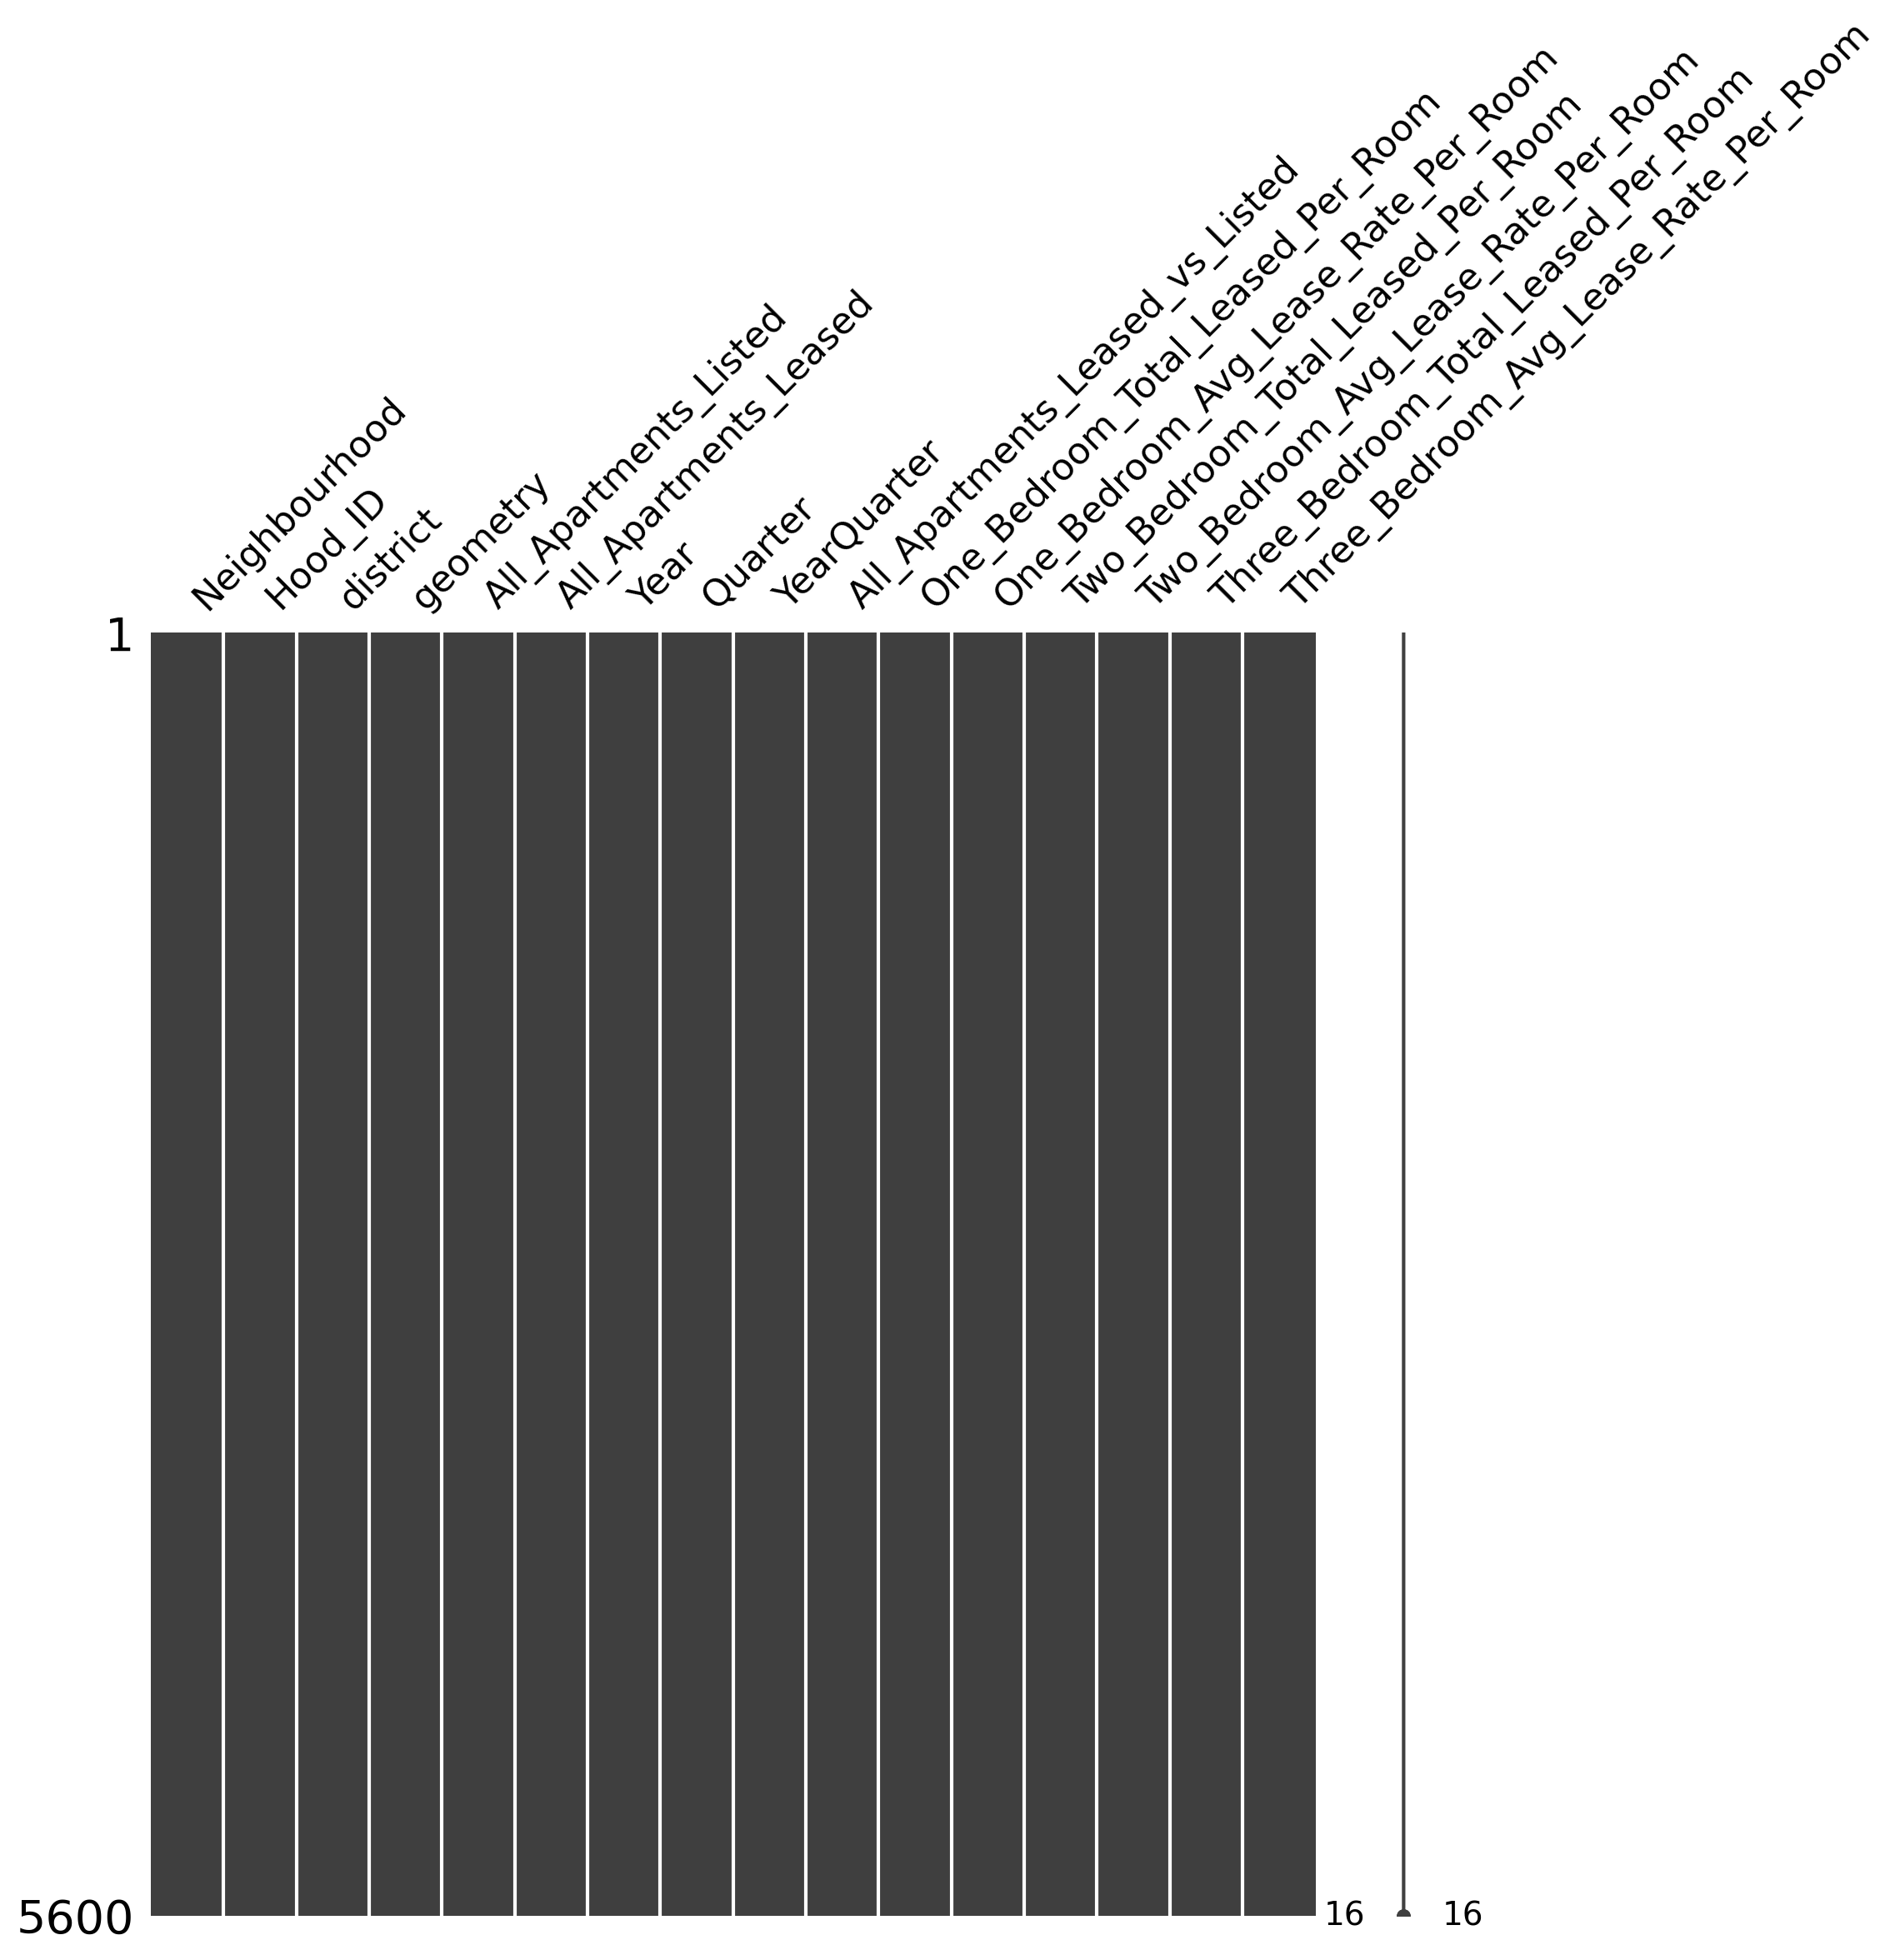

In [114]:
msno.matrix(neighbourhoods_rental, figsize=(10,10))

In [115]:
neighbourhoods_rental

Neighbourhood hood_id district  \
0          Yonge-St.Clair      97      C02   
1          Yonge-St.Clair      97      C02   
2          Yonge-St.Clair      97      C02   
3          Yonge-St.Clair      97      C02   
4          Yonge-St.Clair      97      C02   
...                   ...     ...      ...   
5595  Mount Pleasant West     104      C10   
5596  Mount Pleasant West     104      C10   
5597  Mount Pleasant West     104      C10   
5598  Mount Pleasant West     104      C10   
5599  Mount Pleasant West     104      C10   

                                               geometry  \
0     POLYGON ((-79.39115 43.68108, -79.39137 43.680...   
1     POLYGON ((-79.39115 43.68108, -79.39137 43.680...   
2     POLYGON ((-79.39115 43.68108, -79.39137 43.680...   
3     POLYGON ((-79.39115 43.68108, -79.39137 43.680...   
4     POLYGON ((-79.39115 43.68108, -79.39137 43.680...   
...                                                 ...   
5595  POLYGON ((-79.39607 43.69566, -79.39616 43.696...   
5596  POLYGON ((-79.39607 43.69566, -79.39616 43.696...   
5597  POLYGON ((-79.39607 43.69566, -79.39616 43.696...   
5598  POLYGON ((-79.39607 43.69566, -79.39616 43.696...   
5599  POLYGON ((-79.39607 43.69566, -79.39616 43.696...   

      All_Apartments_Listed  All_Apartments_Leased  Year  Quarter YearQuarter  \
0                     179.0                   92.0  2012        1      2012Q1   
1                     214.0                  105.0  2012        2      2012Q2   
2                     234.0                  107.0  2012        3      2012Q3   
3                     226.0                   82.0  2012        4      2012Q4   
4                     273.0                   95.0  2013        1      2013Q1   
...                     ...                    ...   ...      ...         ...   
5595                 1038.0                  404.0  2020        4      2020Q4   
5596                  970.0                  416.0  2021        1      2021Q1   
5597                 1064.0                  608.0  2021        2      2021Q2   
5598                 1031.0                  767.0  2021        3      2021Q3   
5599                  593.0                  384.0  2021        4      2021Q4   

      All_Apartments_Leased_vs_Listed  One_Bedroom_Total_Leased_Per_Room  \
0                            0.513966                               45.0   
1                            0.490654                               50.0   
2                            0.457265                               57.0   
3                            0.362832                               46.0   
4                            0.347985                               41.0   
...                               ...                                ...   
5595                         0.389210                              267.0   
5596                         0.428866                              281.0   
5597                         0.571429                              409.0   
5598                         0.743938                              501.0   
5599                         0.647555                              242.0   

      One_Bedroom_Avg_Lease_Rate_Per_Room  Two_Bedroom_Total_Leased_Per_Room  \
0                                  2029.0                               84.0   
1                                  1939.0                               90.0   
2                                  2100.0                               82.0   
3                                  2115.0                               58.0   
4                                  2351.0                               94.0   
...                                   ...                                ...   
5595                               1828.0                              242.0   
5596                               1779.0                              230.0   
5597                               1789.0                              348.0   
5598                               1896.0                       

In [116]:
room_types = [re.search("(\w+)_Total_Leased_Per_Room", x).group(1) for x in neighbourhoods_rental.columns if re.search("(\w+)_Total_Leased_Per_Room", x) is not None]
room_types

['One_Bedroom', 'Two_Bedroom', 'Three_Bedroom']

In [117]:
neighbourhoods_rental['All_Apartments_Total_Leased_Per_Room'] = 0
neighbourhoods_rental['All_Apartments_Avg_Lease_Rate_Per_Room'] = 0
for room in room_types:
    neighbourhoods_rental['All_Apartments_Total_Leased_Per_Room'] += neighbourhoods_rental[room + '_Total_Leased_Per_Room']
    neighbourhoods_rental['All_Apartments_Avg_Lease_Rate_Per_Room'] += neighbourhoods_rental[room + '_Avg_Lease_Rate_Per_Room'] * neighbourhoods_rental[room + '_Total_Leased_Per_Room']

neighbourhoods_rental['All_Apartments_Avg_Lease_Rate_Per_Room'] = neighbourhoods_rental['All_Apartments_Avg_Lease_Rate_Per_Room'] / neighbourhoods_rental['All_Apartments_Total_Leased_Per_Room']

In [118]:
neighbourhoods_rental.head()

Neighbourhood hood_id district  \
0  Yonge-St.Clair      97      C02   
1  Yonge-St.Clair      97      C02   
2  Yonge-St.Clair      97      C02   
3  Yonge-St.Clair      97      C02   
4  Yonge-St.Clair      97      C02   

                                            geometry  All_Apartments_Listed  \
0  POLYGON ((-79.39115 43.68108, -79.39137 43.680...                  179.0   
1  POLYGON ((-79.39115 43.68108, -79.39137 43.680...                  214.0   
2  POLYGON ((-79.39115 43.68108, -79.39137 43.680...                  234.0   
3  POLYGON ((-79.39115 43.68108, -79.39137 43.680...                  226.0   
4  POLYGON ((-79.39115 43.68108, -79.39137 43.680...                  273.0   

   All_Apartments_Leased  Year  Quarter YearQuarter  \
0                   92.0  2012        1      2012Q1   
1                  105.0  2012        2      2012Q2   
2                  107.0  2012        3      2012Q3   
3                   82.0  2012        4      2012Q4   
4                   95.0  2013        1      2013Q1   

   All_Apartments_Leased_vs_Listed  One_Bedroom_Total_Leased_Per_Room  \
0                         0.513966                               45.0   
1                         0.490654                               50.0   
2                         0.457265                               57.0   
3                         0.362832                               46.0   
4                         0.347985                               41.0   

   One_Bedroom_Avg_Lease_Rate_Per_Room  Two_Bedroom_Total_Leased_Per_Room  \
0                               2029.0                               84.0   
1                               1939.0                               90.0   
2                               2100.0                               82.0   
3                               2115.0                               58.0   
4                               2351.0                               94.0   

   Two_Bedroom_Avg_Lease_Rate_Per_Room  Three_Bedroom_Total_Leased_Per_Room  \
0                               2052.0                                  3.0   
1                               1959.0                                 12.0   
2                               2009.5                                 12.0   
3                               1698.5                                  9.0   
4                               2123.5                                  9.0   

   Three_Bedroom_Avg_Lease_Rate_Per_Room  \
0                            1333.333333   
1                            1991.666667   
2                            2299.333333   
3                            1466.666667   
4                            1850.000000   

   All_Apartments_Total_Leased_Per_Room  \
0                                 132.0   
1                                 152.0   
2                                 151.0   
3                                 113.0   
4                                 144.0   

   All_Apartments_Avg_Lease_Rate_Per_Room  
0                             2027.825758  
1                             1955.000000  
2                             2066.695364  
3                             1849.584071  
4                             2171.180556

In [119]:
neighbourhoods_rental.to_file('./clean_data/neighbourhoods_rental.geojson', driver='GeoJSON')

C:\Users\willi\miniconda3\envs\police\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


# Improvements
- Reference for getting data from zumper: https://medium.com/@backupfairuz/exploring-rental-rates-in-canada-hands-on-project-making-use-of-foursquare-api-with-python-413793d2dfca

In [ ]:
# Improvement
# bungol.ca for data of housing transaction prices (not listing like other websites)
# real transaction data instead of listings
# access to paid APIs https://rapidapi.com/blog/best-real-estate-apis/